# Playing with Ohio's Covid-19 Data 
This is a small demonstration notebook showing how to do some graphical analysis using COVID-19 data that has been supplied by the State of Ohio.

## Goals:
1. To have some fun while physically distancing
2. Demonstrate some graphical analysis using Python, Pandas, and Matplotlib
3. Try to reproduce some of Ohio's COVID-19 Dashboard (https://coronavirus.ohio.gov/wps/portal/gov/covid-19/dashboards)

In [2]:
# Import the libararies that we will need
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np

from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
    
plt.style.use('fivethirtyeight')

# Read the data provided from the web.
df = pd.read_csv("https://coronavirus.ohio.gov/static/dashboards/COVIDSummaryData.csv", low_memory=False)

# Read data from the web
Terms and definitions available at https://coronavirus.ohio.gov/static/docs/COVID-19-Data-Term-Definitions.pdf

In [3]:
# Read the data provided from the web.
# df = pd.read_csv("https://coronavirus.ohio.gov/static/COVIDSummaryData.csv", low_memory=False)
df = pd.read_csv("https://coronavirus.ohio.gov/static/dashboards/COVIDSummaryData.csv", low_memory=False)
df.columns

Index(['County', 'Sex', 'Age Range', 'Onset Date', 'Date Of Death',
       'Admission Date', 'Case Count', 'Death Due to Illness Count',
       'Hospitalized Count'],
      dtype='object')

# Convert data types
Many of the columns are not in the proper data type, particularly those that are dates. In addition, the last row is a row of totals.

In [4]:
# Drop Totals in last row
df = df.drop(df.index[df.shape[0]-1])

# Fix some type issues, converting certain values to numbers and making sure that dates are dates
df["Case Count"] = pd.to_numeric(df["Case Count"])
df["Hospitalized Count"] = pd.to_numeric(df["Hospitalized Count"])
df["Death Count"] = pd.to_numeric(df["Death Due to Illness Count"])
df["Onset Date"] = pd.to_datetime(df["Onset Date"])

# Also must deal with "Unknown types"
df['Date Of Death'] = df['Date Of Death'].replace(['Unknown'],'2020/03/01')
df["Date Of Death"] = pd.to_datetime(df["Date Of Death"])

df['Admission Date'] = df['Admission Date'].replace(['Unknown'],'2020/03/01')
df["Admission Date"] = pd.to_datetime(df["Admission Date"])

# Calculate Case Death/Hospitalization/Non-Severe Rates

In [5]:
# Sum up the total Cases, Deaths, and Hospitalizations
TotalCases  = int(df[["Case Count"]].sum())
TotalDeaths = int(df[["Death Count"]].sum())
TotalHospitalization = int(df[["Hospitalized Count"]].sum())

# print(TotalDeaths)
# Print with some nice formatting
print("Total Cases:", "{0:,}".format(TotalCases))
print("Total Deaths:", "{0:,} ({1:.2f}%)".format(TotalDeaths, TotalDeaths/TotalCases*100))
print("Total Hospitalizations:", "{0:,} ({1:.2f}%)".format(TotalHospitalization, TotalHospitalization/TotalCases*100))

n = TotalCases-(TotalHospitalization+TotalDeaths)
print("Non Severe Cases:", "{0:,} ({1:.2f}%)".format(n, n/TotalCases*100))

Total Cases: 437,928
Total Deaths: 6,671 (1.52%)
Total Hospitalizations: 27,885 (6.37%)
Non Severe Cases: 403,372 (92.11%)


# Adjustments with multiplier
The CDC has calculated the actual IFR to be .64%. That means that TotalCases * IFR = TotalDeaths. In other words, we can calculate how many cases there should be by dividing TotalDeaths by the IFR. The planning scenarios can be found at https://www.cdc.gov/coronavirus/2019-ncov/hcp/planning-scenarios.html. 

TODO: Adjust this based on age-based analysis, i.e. the TotalDeaths in each age goup divd

In [6]:
TotalActualCases = TotalDeaths/.0054 # https://www.cdc.gov/coronavirus/2019-ncov/hcp/planning-scenarios.html

print("Estimated Total Cases:", "{0:,}".format(TotalActualCases))
print("Total Deaths:", "{0:,} ({1:.2f}%)".format(TotalDeaths, TotalDeaths/TotalActualCases*100))
print("Total Hospitalizations:", "{0:,} ({1:.2f}%)".format(TotalHospitalization, TotalHospitalization/TotalActualCases*100))

n = TotalActualCases-(TotalHospitalization+TotalDeaths)
print("Non Severe Cases:", "{0:,} ({1:.2f}%)".format(n, n/TotalActualCases*100))
print("Likely updated on: ", df["Onset Date"].max())


Estimated Total Cases: 1,235,370.3703703703
Total Deaths: 6,671 (0.54%)
Total Hospitalizations: 27,885 (2.26%)
Non Severe Cases: 1,200,814.3703703703 (97.20%)
Likely updated on:  2020-12-02 00:00:00


In [7]:
# Various Groupings of Interest
dfAge     = df.groupby(["Age Range"])
dfDate    = df.groupby(["Onset Date"])
dfSex     = df.groupby(["Sex"])
dfCounty  = df.groupby(["County"])

dfAgeDate  = df.groupby(["Age Range","Onset Date"])
dfDeathDate = df.groupby(["Date Of Death"])
dfHospDate  = df.groupby(["Admission Date"])

dfCaseAgeDate  = df.groupby(["Age Range","Onset Date"])
dfDeathAgeDate = df.groupby(["Age Range", "Date Of Death"])
dfHospAgeDate  = df.groupby(["Age Range", "Admission Date"])

# Age Grouped Statistics

In [8]:
dfAgeTotals = pd.DataFrame()

# Totals by Age
dfAgeTotals["Deaths"]       = dfAge["Death Count"].sum()
dfAgeTotals["Hospitalized"] = dfAge["Hospitalized Count"].sum()
dfAgeTotals["Cases"]        = dfAge["Case Count"].sum()

# Percentages based on Overall Case Count
dfAgeTotals["DeathPerc"]        = dfAge["Death Count"].sum()/TotalCases*100
dfAgeTotals["HospitalizedPerc"] = dfAge["Hospitalized Count"].sum()/TotalCases*100
dfAgeTotals["CasesPerc"]        = dfAge["Case Count"].sum()/TotalCases*100

dfAgeTotals["PercTotalDeaths"]  = dfAge["Death Count"].sum()/TotalDeaths*100
dfAgeTotals["PercTotalHosps"]   = dfAge["Hospitalized Count"].sum()/TotalHospitalization*100

# Percentage of Age Group
dfAgeTotals["DeathPercAge"]        = dfAge["Death Count"].sum()/dfAge["Case Count"].sum()*100
dfAgeTotals["HospitalizedPercAge"] = dfAge["Hospitalized Count"].sum()/dfAge["Case Count"].sum()*100

dfAgeTotals["Non Severe Case %"] = 100-dfAgeTotals["DeathPercAge"]-dfAgeTotals["HospitalizedPercAge"]

# Include index as column for later use
dfAgeTotals["Age Range"] = dfAgeTotals.index
# dfAgeTotals

dfAgeTotalsStyled = dfAgeTotals.style.format({
    'Deaths': '{:,.0f}'.format,
    'Hospitalized': '{:,.0f}'.format,
    'Cases': '{:,.0f}'.format,
    'HospitalizedPerc': '{:,.2f} %'.format,
    'CasesPerc': '{:,.2f} %'.format,
    'PercTotalDeaths': '{:,.2f} %'.format,
    'PercTotalHosps': '{:,.2f} %'.format,
    'DeathPerc': '{:,.2f} %'.format,
    'HospitalizedPercAge': '{:,.2f} %'.format,
    'DeathPercAge': '{:,.2f} %'.format,
    'Non Severe Case %': '{:,.2f} %'.format
})

dfAgeTotalsStyled

# print(dfAgeTotals["DeathPerc"].mean())

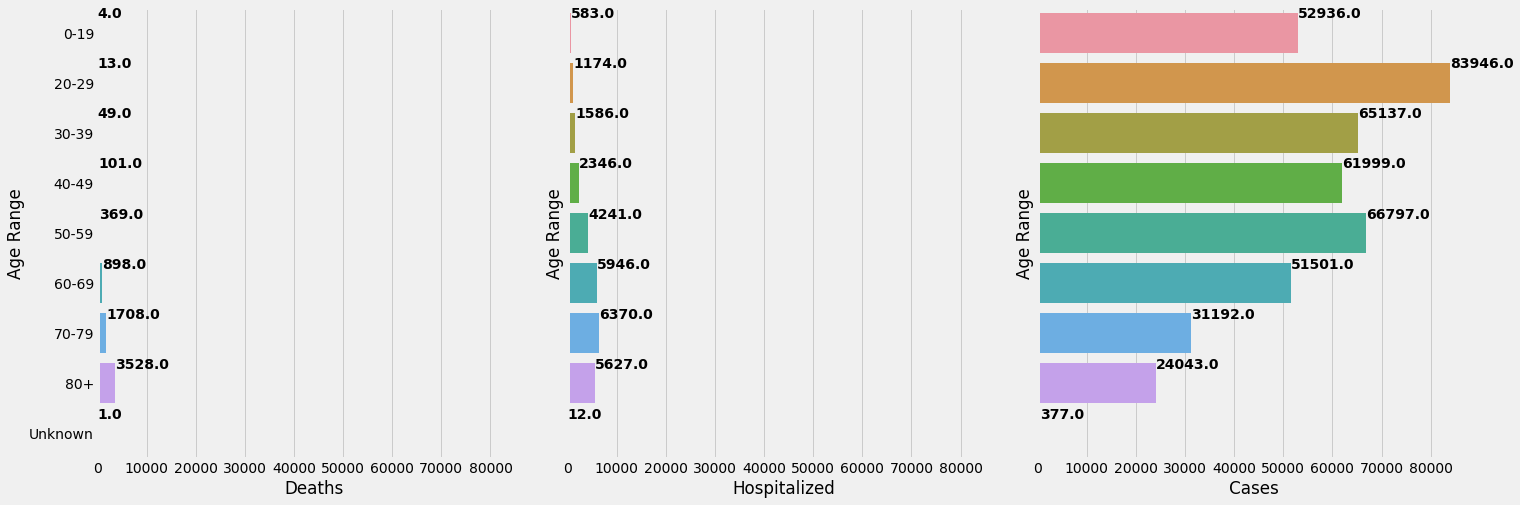

In [9]:
fig, ax = plt.subplots(1,3, sharey=True, sharex=True, figsize=(20,7))
fig.tight_layout()

plots = []
plots.append(sns.barplot(x="Deaths", y="Age Range", data=dfAgeTotals, ax=ax[0]))
plots.append(sns.barplot(x="Hospitalized", y="Age Range", data=dfAgeTotals, ax=ax[1]))
plots.append(sns.barplot(x="Cases", y="Age Range", data=dfAgeTotals, ax=ax[2]))
for p in plots:
    for i in p.patches:
        # get_width pulls left or right; get_y pushes up or down
        p.text(i.get_width()+.75, i.get_y()+.1, str(round(i.get_width(), 2)),fontsize=14, fontweight="bold", color='black')

plt.show()


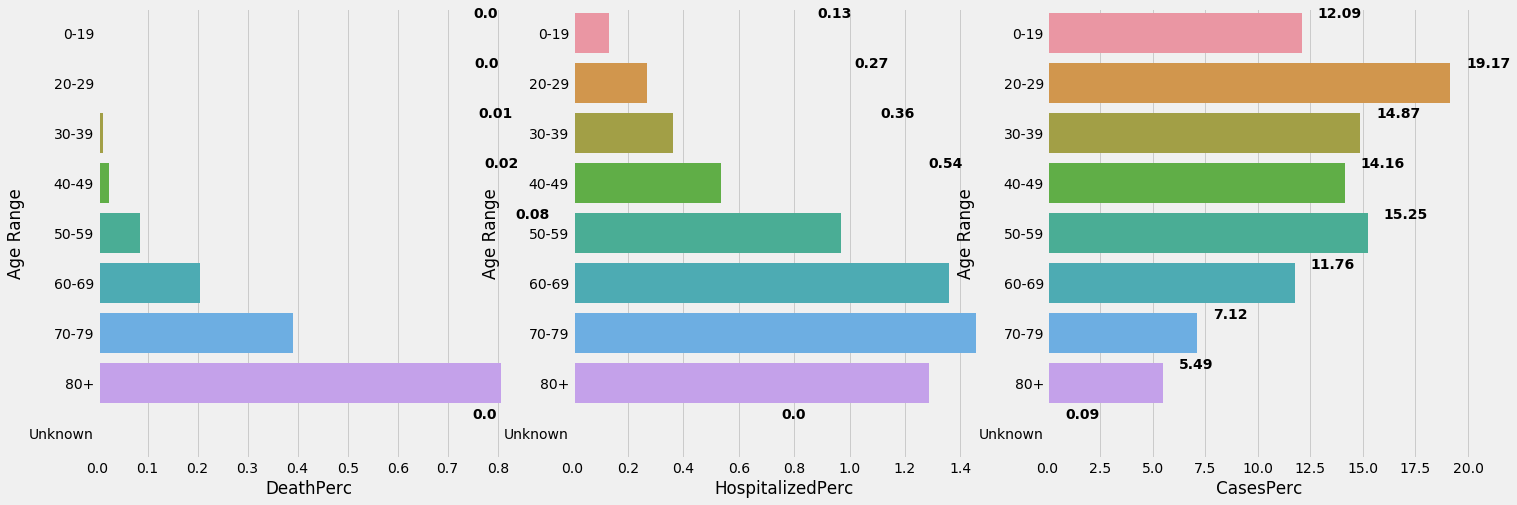

In [10]:
fig, ax = plt.subplots(1,3, figsize=(20,7))
fig.tight_layout()  

plots = []
plots.append(sns.barplot(x="DeathPerc", y="Age Range", data=dfAgeTotals, ax=ax[0]))
plots.append(sns.barplot(x="HospitalizedPerc", y="Age Range", data=dfAgeTotals, ax=ax[1]))
plots.append(sns.barplot(x="CasesPerc", y="Age Range", data=dfAgeTotals, ax=ax[2]))

for p in plots:
    for i in p.patches:
        # get_width pulls left or right; get_y pushes up or down
        p.text(i.get_width()+.75, i.get_y()+.1, str(round(i.get_width(), 2)),fontsize=14, fontweight="bold", color='black')
plt.show()


In [11]:
# dfAgeTotals = pd.DataFrame()

# dfAge = df[(df["Onset Date"] >= "2020-10-01") | (df["Admission Date"] >= "2020-10-01")  | (df["Date Of Death"] >= "2020-10-01")].groupby(["Age Range"])

# # Totals by Age
# dfAgeTotals["Deaths"]       = dfAge["Death Count"].sum()
# dfAgeTotals["Hospitalized"] = dfAge["Hospitalized Count"].sum()
# dfAgeTotals["Cases"]        = dfAge["Case Count"].sum()

# # Percentages based on Overall Case Count
# dfAgeTotals["DeathPerc"]        = dfAge["Death Count"].sum()/TotalCases*100
# dfAgeTotals["HospitalizedPerc"] = dfAge["Hospitalized Count"].sum()/TotalCases*100
# dfAgeTotals["CasesPerc"]        = dfAge["Case Count"].sum()/TotalCases*100

# # Percentage of Age Group
# dfAgeTotals["DeathPercAge"]        = dfAge["Death Count"].sum()/dfAge["Case Count"].sum()*100
# dfAgeTotals["HospitalizedPercAge"] = dfAge["Hospitalized Count"].sum()/dfAge["Case Count"].sum()*100

# dfAgeTotals["Non Severe Case %"] = 100-dfAgeTotals["DeathPercAge"]-dfAgeTotals["HospitalizedPercAge"]

# # Include index as column for later use
# dfAgeTotals["Age Range"] = dfAgeTotals.index
# # dfAgeTotals

# dfAgeTotalsStyled = dfAgeTotals.style.format({
#     'HospitalizedPerc': '{:,.2f} %'.format,
#     'CasesPerc': '{:,.2f} %'.format,
#     'DeathPerc': '{:,.2f} %'.format,
#     'HospitalizedPercAge': '{:,.2f} %'.format,
#     'DeathPercAge': '{:,.2f} %'.format,
#     'Non Severe Case %': '{:,.2f} %'.format
# })

# dfAgeTotalsStyled

# # print(dfAgeTotals["DeathPerc"].mean())

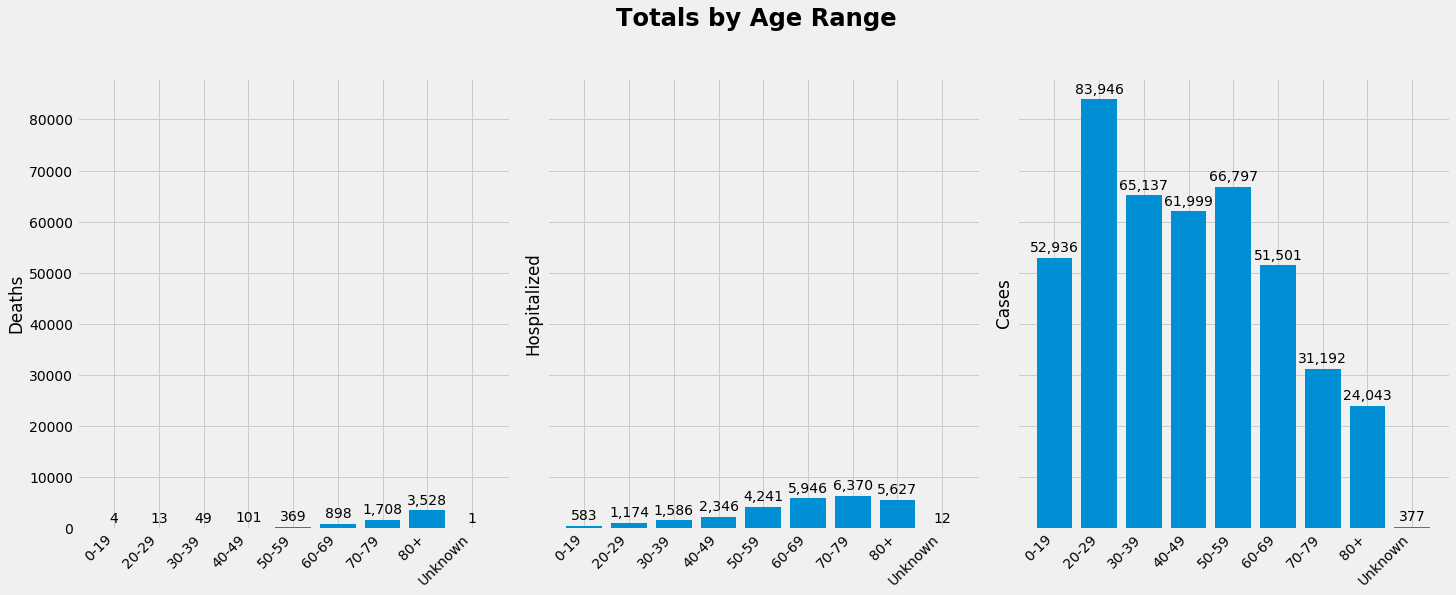

In [12]:
# Taken from the Matplotlib website, butmodified to include formatting
def autolabel(ax, rects, labelFormat="{:}", xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate(labelFormat.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')
        
        
# Create a new sbuplot with 1 row, 3 items
fig, ax = plt.subplots(1,3, sharey=True, figsize=(20,7))
fig.tight_layout()

# Plot, label, and format
r = ax[0].bar(dfAgeTotals["Age Range"], dfAgeTotals["Deaths"])
ax[0].set_ylabel('Deaths')
ax[0].set_xticklabels(dfAgeTotals["Age Range"], rotation=45, ha='right')
autolabel(ax[0], r, labelFormat="{:,}")

r = ax[1].bar(dfAgeTotals["Age Range"], dfAgeTotals["Hospitalized"])
ax[1].set_ylabel('Hospitalized')
ax[1].set_xticklabels(dfAgeTotals["Age Range"], rotation=45, ha='right')
autolabel(ax[1], r, labelFormat="{:,}")

r = ax[2].bar(dfAgeTotals["Age Range"], dfAgeTotals["Cases"])
ax[2].set_ylabel('Cases')
ax[2].set_xticklabels(dfAgeTotals["Age Range"], rotation=45, ha='right')
autolabel(ax[2], r, labelFormat="{:,}")

fig.suptitle("Totals by Age Range", y=1.1, fontsize="xx-large", fontweight="bold")

plt.show()

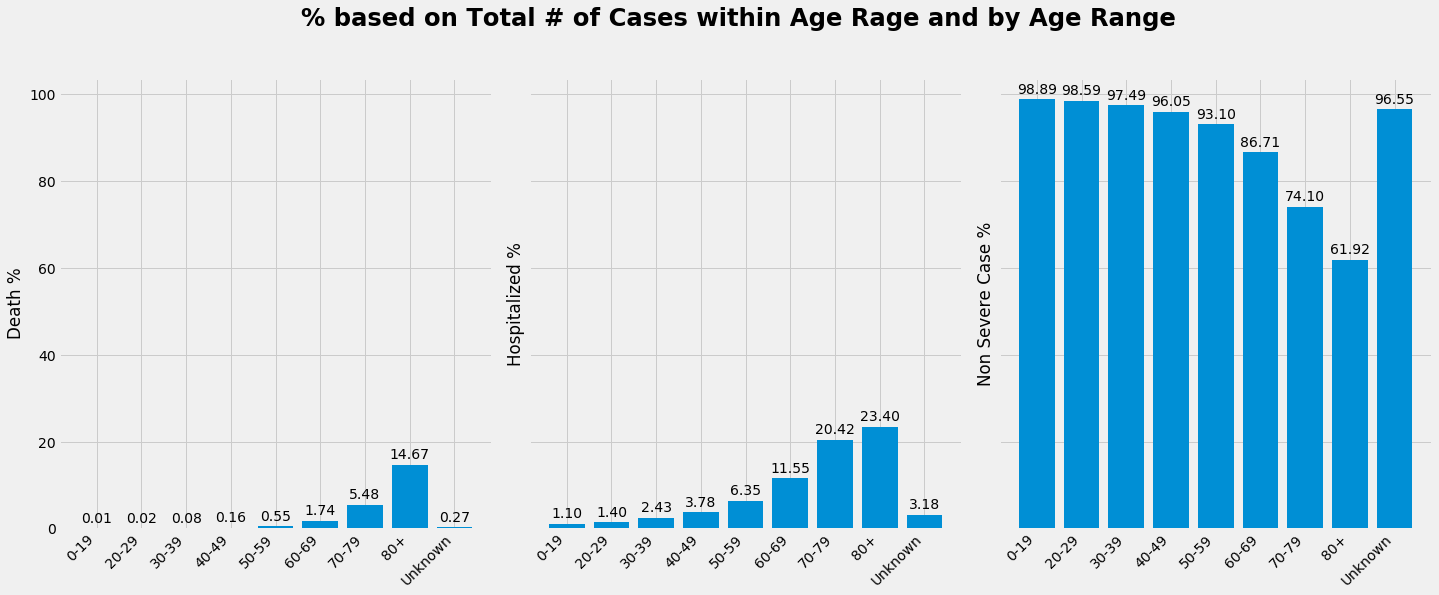

In [13]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(20,7))
fig.tight_layout()

r = ax[0].bar(dfAgeTotals["Age Range"], dfAgeTotals["DeathPercAge"])
ax[0].set_ylabel('Death %')
ax[0].set_xticklabels(dfAgeTotals["Age Range"], rotation=45, ha='right')
autolabel(ax[0], r, labelFormat="{:.2f}")

r = ax[1].bar(dfAgeTotals["Age Range"], dfAgeTotals["HospitalizedPercAge"])
ax[1].set_ylabel('Hospitalized %')
ax[1].set_xticklabels(dfAgeTotals["Age Range"], rotation=45, ha='right')
autolabel(ax[1], r, labelFormat="{:.2f}")

r = ax[2].bar(dfAgeTotals["Age Range"], dfAgeTotals["Non Severe Case %"])
ax[2].set_ylabel('Non Severe Case %')
ax[2].set_xticklabels(dfAgeTotals["Age Range"], rotation=45, ha='right')
autolabel(ax[2], r, labelFormat="{:.2f}")

fig.suptitle("% based on Total # of Cases within Age Rage and by Age Range", y=1.1, fontsize="xx-large", fontweight="bold")
plt.show()

/Users/greenr/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/greenr/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/greenr/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


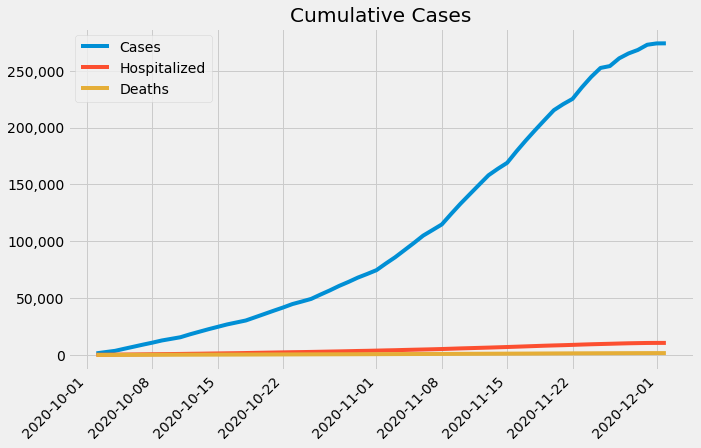

In [14]:
# By Date
dfTotals = pd.DataFrame()

dfTotals["Deaths"]       = dfDeathDate["Death Count"].sum()
dfTotals["Hospitalized"] = dfHospDate["Hospitalized Count"].sum()
dfTotals["Cases"]        = dfDate["Case Count"].sum()

dfTotals = dfTotals[dfTotals.index > "2020-10-01"]
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(10,7))
plt.plot(dfTotals.index, dfTotals.cumsum()["Cases"], label="Cases")
plt.plot(dfTotals.index, dfTotals.cumsum()["Hospitalized"], label="Hospitalized")
plt.plot(dfTotals.index, dfTotals.cumsum()["Deaths"], label="Deaths")
plt.legend()

plt.title("Cumulative Cases")
fig.autofmt_xdate(rotation=45)
    
t = ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

plt.show()

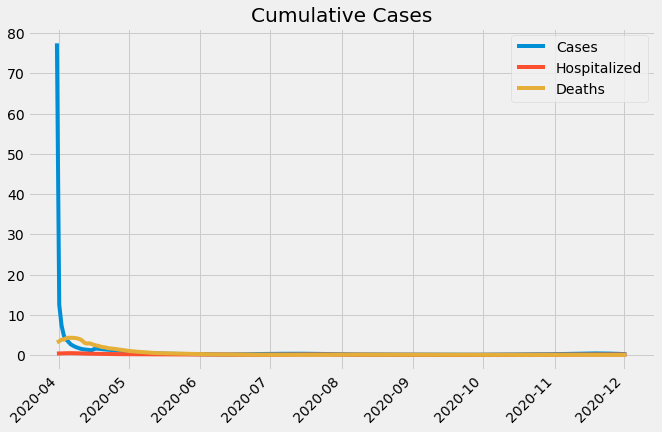

In [15]:
# By Date
dfTotals = pd.DataFrame()

dfTotals["Deaths"]       = dfDeathDate["Death Count"].sum()
dfTotals["Hospitalized"] = dfHospDate["Hospitalized Count"].sum()
dfTotals["Cases"]        = dfDate["Case Count"].sum()

# dfTotals = dfTotals[dfTotals.index > "2020-10-01"]
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(10,7))
plt.plot(dfTotals.index, dfTotals.cumsum()["Cases"].pct_change(14), label="Cases")
plt.plot(dfTotals.index, dfTotals.cumsum()["Hospitalized"].pct_change(14), label="Hospitalized")
plt.plot(dfTotals.index, dfTotals.cumsum()["Deaths"].pct_change(14), label="Deaths")
plt.legend()

plt.title("Cumulative Cases")
fig.autofmt_xdate(rotation=45)
    
t = ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

plt.show()

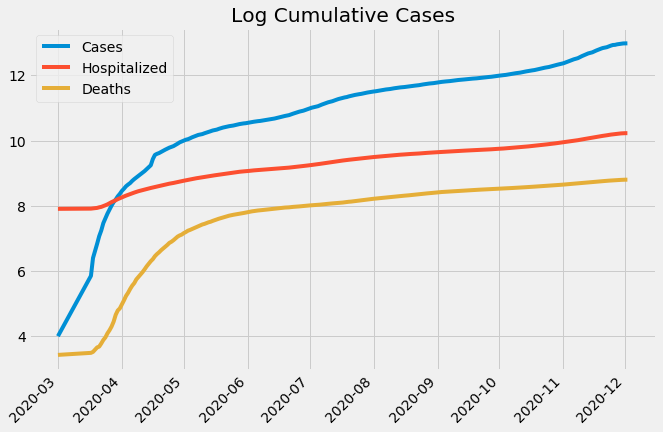

In [16]:
pd.set_option('use_inf_as_na', True)
dfLog = dfTotals.cumsum()

dfLog['Deaths'] = dfLog['Deaths'].apply(lambda x: np.log(x) if x > 0 else 0)
dfLog['Hospitalized'] = dfLog['Hospitalized'].apply(lambda x: np.log(x) if x > 0 else 0)
dfLog['Cases'] = dfLog['Cases'].apply(lambda x: np.log(x) if x > 0 else 0)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(10,7))
ax.plot(dfLog.index, dfLog["Cases"], label="Cases")
ax.plot(dfLog.index, dfLog["Hospitalized"], label="Hospitalized")
ax.plot(dfLog.index, dfLog["Deaths"], label="Deaths")
ax.legend()

plt.title("Log Cumulative Cases")
fig.autofmt_xdate(rotation=45)
        
t = ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

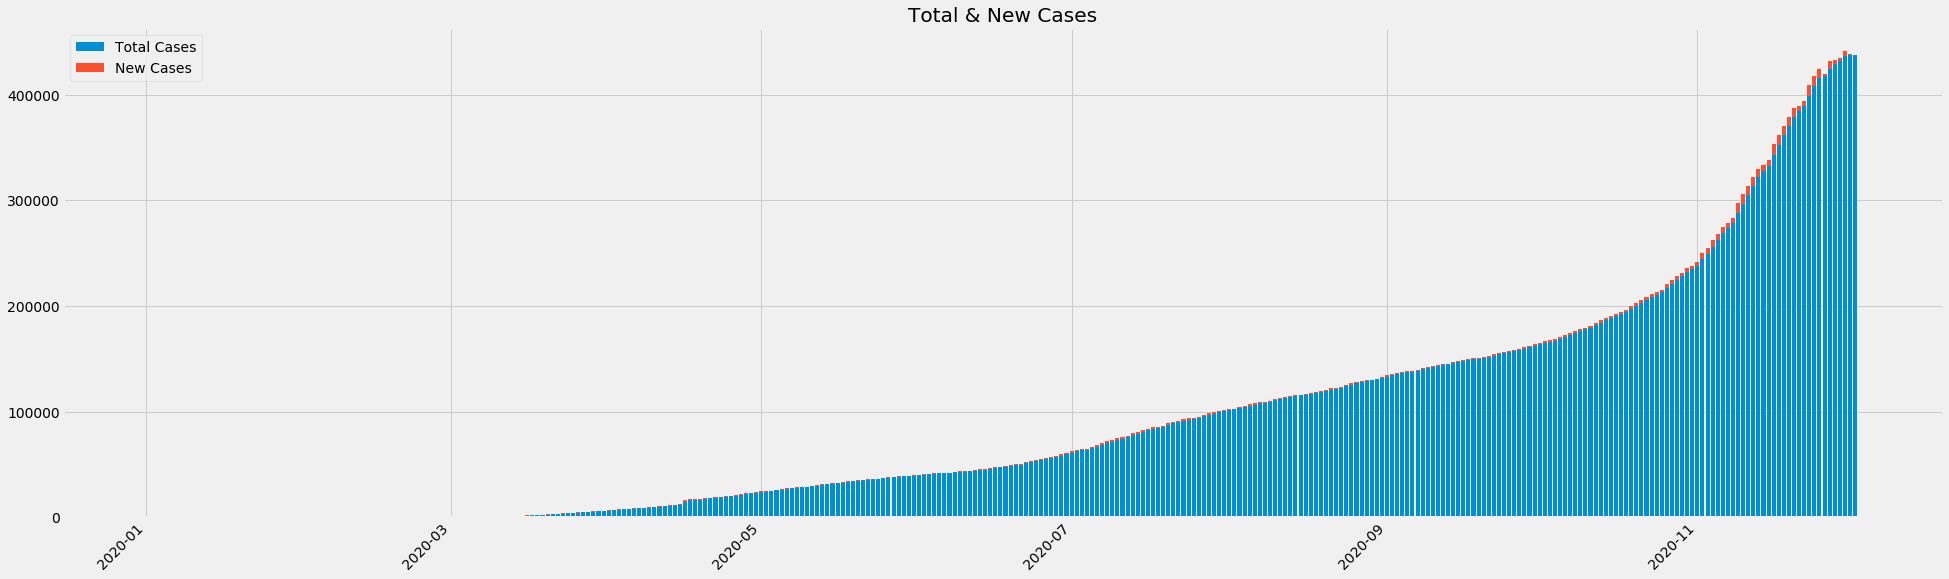

In [17]:
# Stacked Bar Chart of New/Current cases by date
d = pd.DataFrame()
d["New Cases"] = dfDate["Case Count"].sum()
d["New Hospitilizations"] = dfHospDate["Hospitalized Count"].sum()
d["New Deaths"] = dfDeathDate["Death Count"].sum()
totalCases = []
for row in d.itertuples():
    if len(totalCases) > 0:
        totalCases.append(row[1] + totalCases[len(totalCases)-1])
    else:
        totalCases.append(row[1])
        

d["Total Cases"] = totalCases

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(30,10))
ax.bar(d.index, d["Total Cases"], label='Total Cases')
ax.bar(d.index, d["New Cases"], bottom=d["Total Cases"], label='New Cases')

fig.autofmt_xdate(rotation=45)

plt.legend()
plt.title("Total & New Cases")
plt.show()

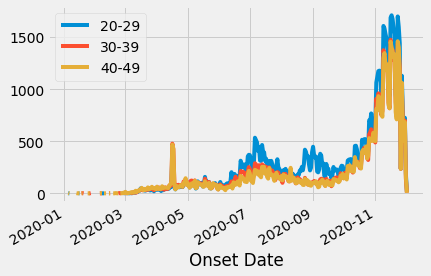

In [18]:
from datetime import datetime, timedelta

d = pd.DataFrame()
d["New Cases"] = dfAgeDate["Case Count"].sum()
# dfAgeDate
# d.reset_index(inplace=True)
d = d.unstack(level=0)
# d.plot()
# d["0-19"].plot()
#0-19  20-29  30-39  40-49  50-59  60-69  70-79    80+
# print(d["New Cases"])

# print(d["New Cases"]["0-19"].median())
# print(d["New Cases"]["20-29"].median())
# print(d["New Cases"]["30-39"].median())
# print(d["New Cases"]["40-49"].median())
# print(d["New Cases"]["50-59"].median())
# print(d["New Cases"]["60-69"].median())
# print(d["New Cases"]["70-79"].median())

d["New Cases"]["20-29"].plot()
d["New Cases"]["30-39"].plot()
d["New Cases"]["40-49"].plot()
# fig, ax = plt.subplots(2, 4, sharey=True, figsize=(20,20))
# d["New Cases"]["0-19"].plot(ax=ax[0][0], kind="bar")
# # d["New Cases"]["20-29"].plot(ax=ax[0][1], kind="bar")
# # d["New Cases"]["30-39"].plot(ax=ax[0][2], kind="bar")
# # d["New Cases"]["40-49"].plot(ax=ax[0][3], kind="bar")
# # d["New Cases"]["50-59"].plot(ax=ax[1][0], kind="bar")
# # d["New Cases"]["60-69"].plot(ax=ax[1][1], kind="bar")
# # d["New Cases"]["70-79"].plot(ax=ax[1][2], kind="bar")
# # d["New Cases"]["80+"].plot(ax=ax[1][3], kind="bar")

plt.legend()
# plt.show()


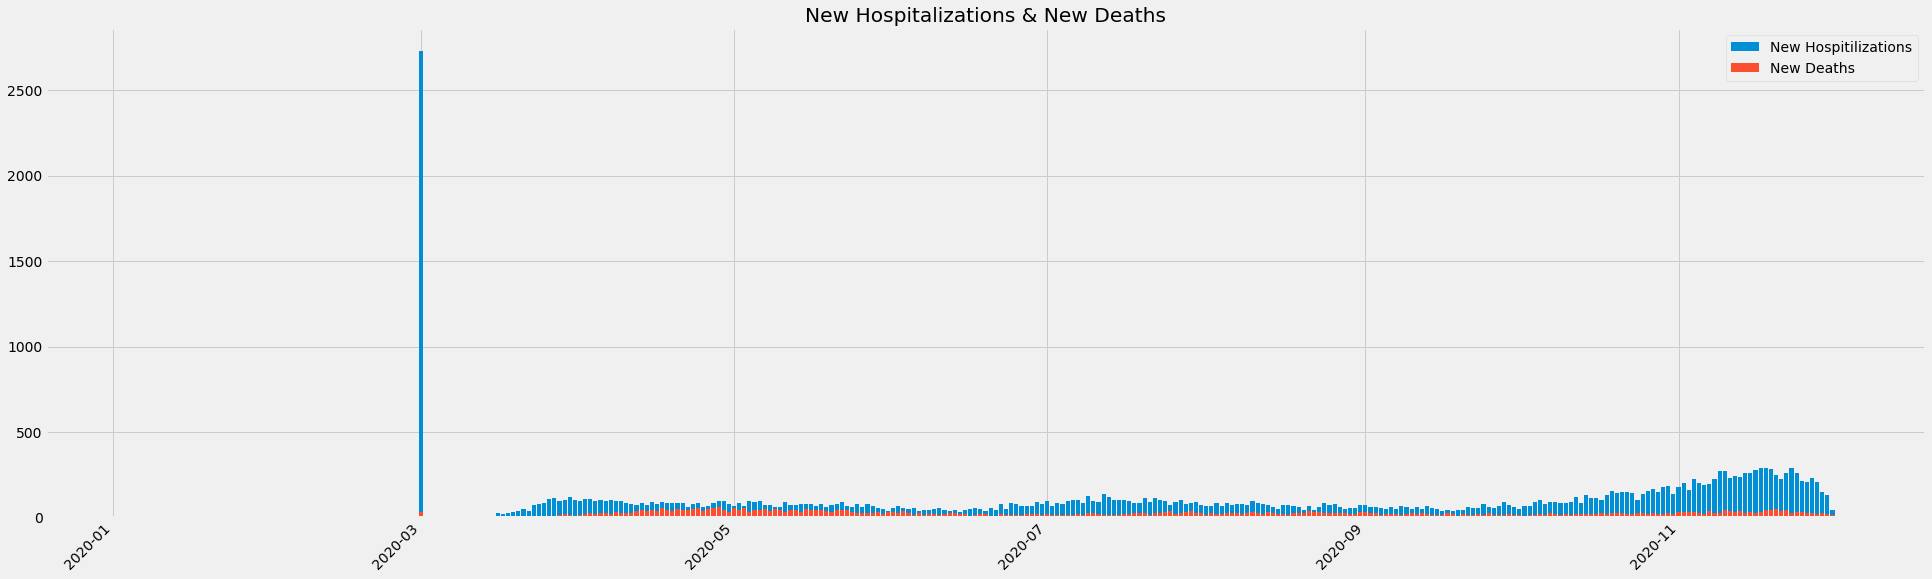

In [19]:
# Stacked Bar Chart of New/Current cases by date
# d = pd.DataFrame()
d["New Cases"] = dfDate["Case Count"].sum()
d["New Hospitilizations"] = dfHospDate["Hospitalized Count"].sum()
d["New Deaths"] = dfDeathDate["Death Count"].sum()
# totalCases = []
# for row in d.itertuples():
#     if len(totalCases) > 0:
#         totalCases.append(row[1] + totalCases[len(totalCases)-1])
#     else:
#         totalCases.append(row[1])

# d["Total Cases"] = totalCases

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(30,10))
# ax.bar(d.index, d["Total Cases"], label='Total Cases')
# ax.bar(d.index, d["New Cases"], label="New Cases")
ax.bar(d.index, d["New Hospitilizations"], label="New Hospitilizations")
ax.bar(d.index, d["New Deaths"], label="New Deaths")

fig.autofmt_xdate(rotation=45)

plt.legend()
plt.title("New Hospitalizations & New Deaths")
plt.show()

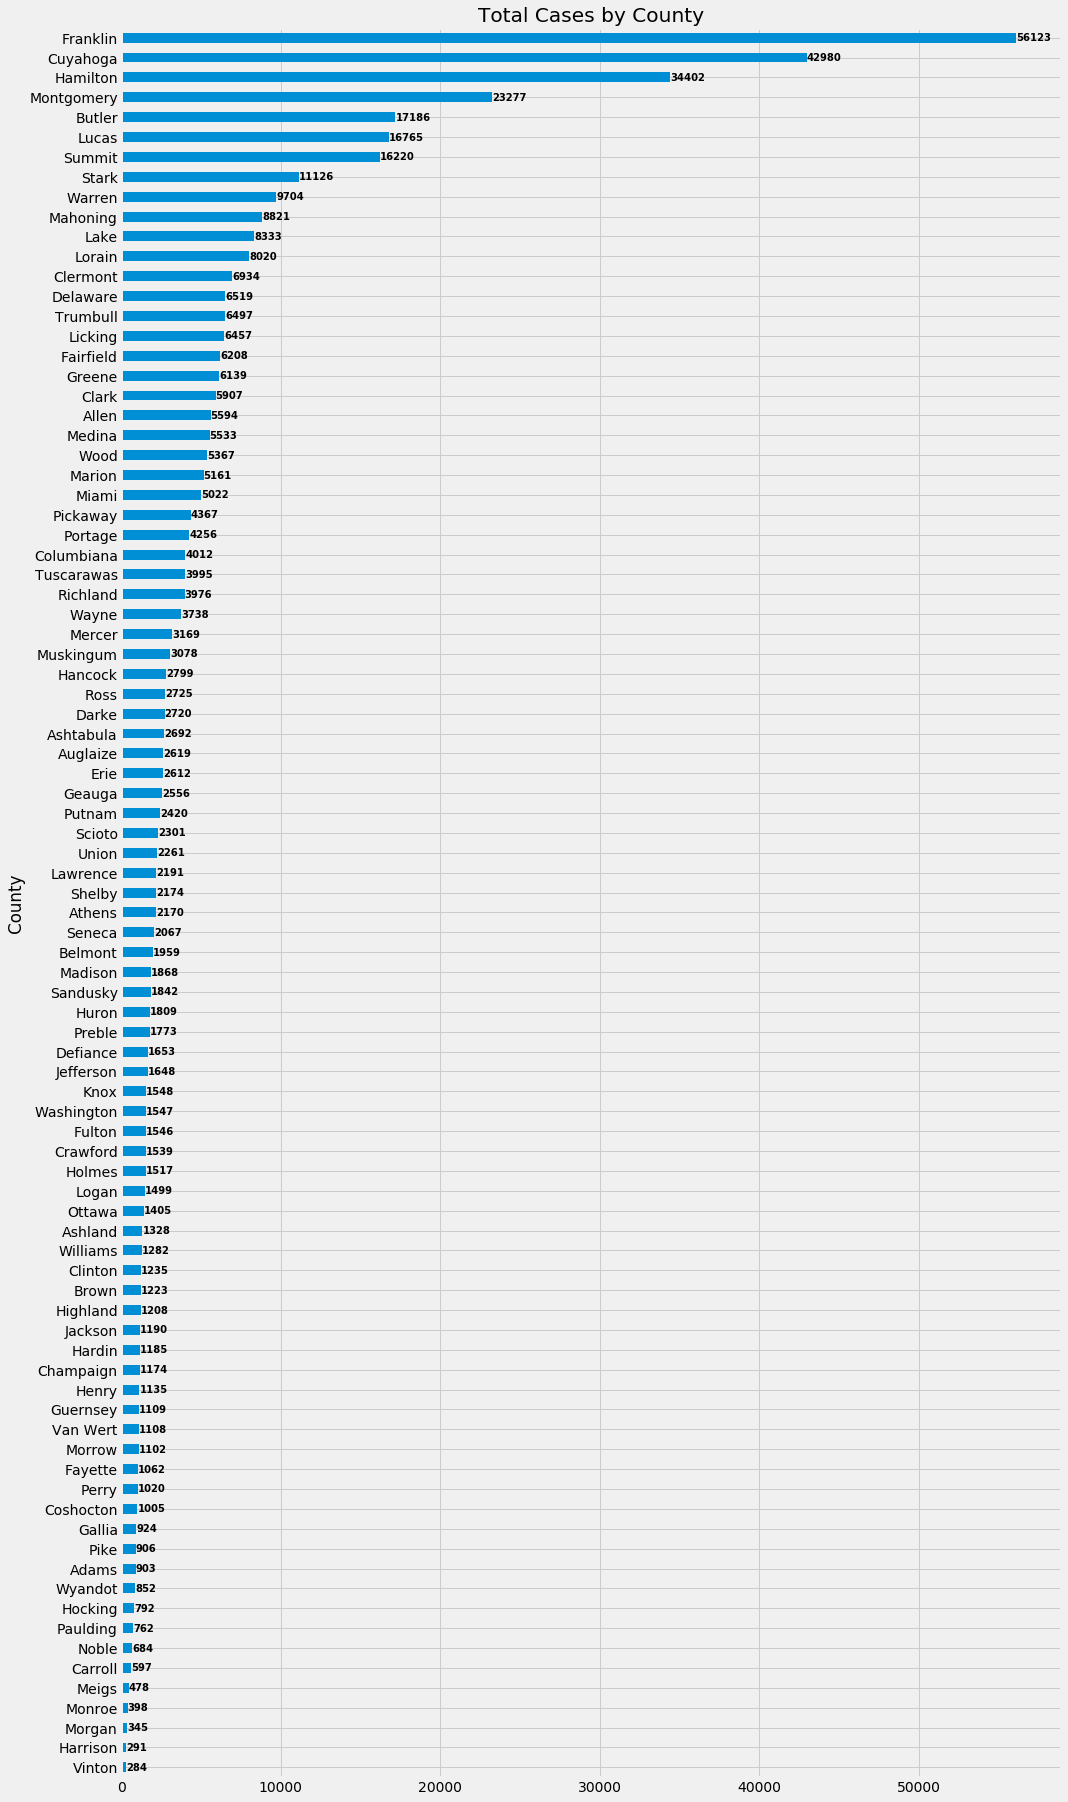

In [20]:
# By County
dfCounty  = df.groupby(["County"]).sum()

dfCounty.sort_values(by=["Case Count"], inplace=True, ascending=True)
ax = dfCounty["Case Count"].plot(kind="barh", figsize=(15,30))

totals = []
# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())
    
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.75, i.get_y()+.1, str(round(i.get_width(), 2)),fontsize=10, fontweight="bold", color='black')


plt.title("Total Cases by County")
plt.show()

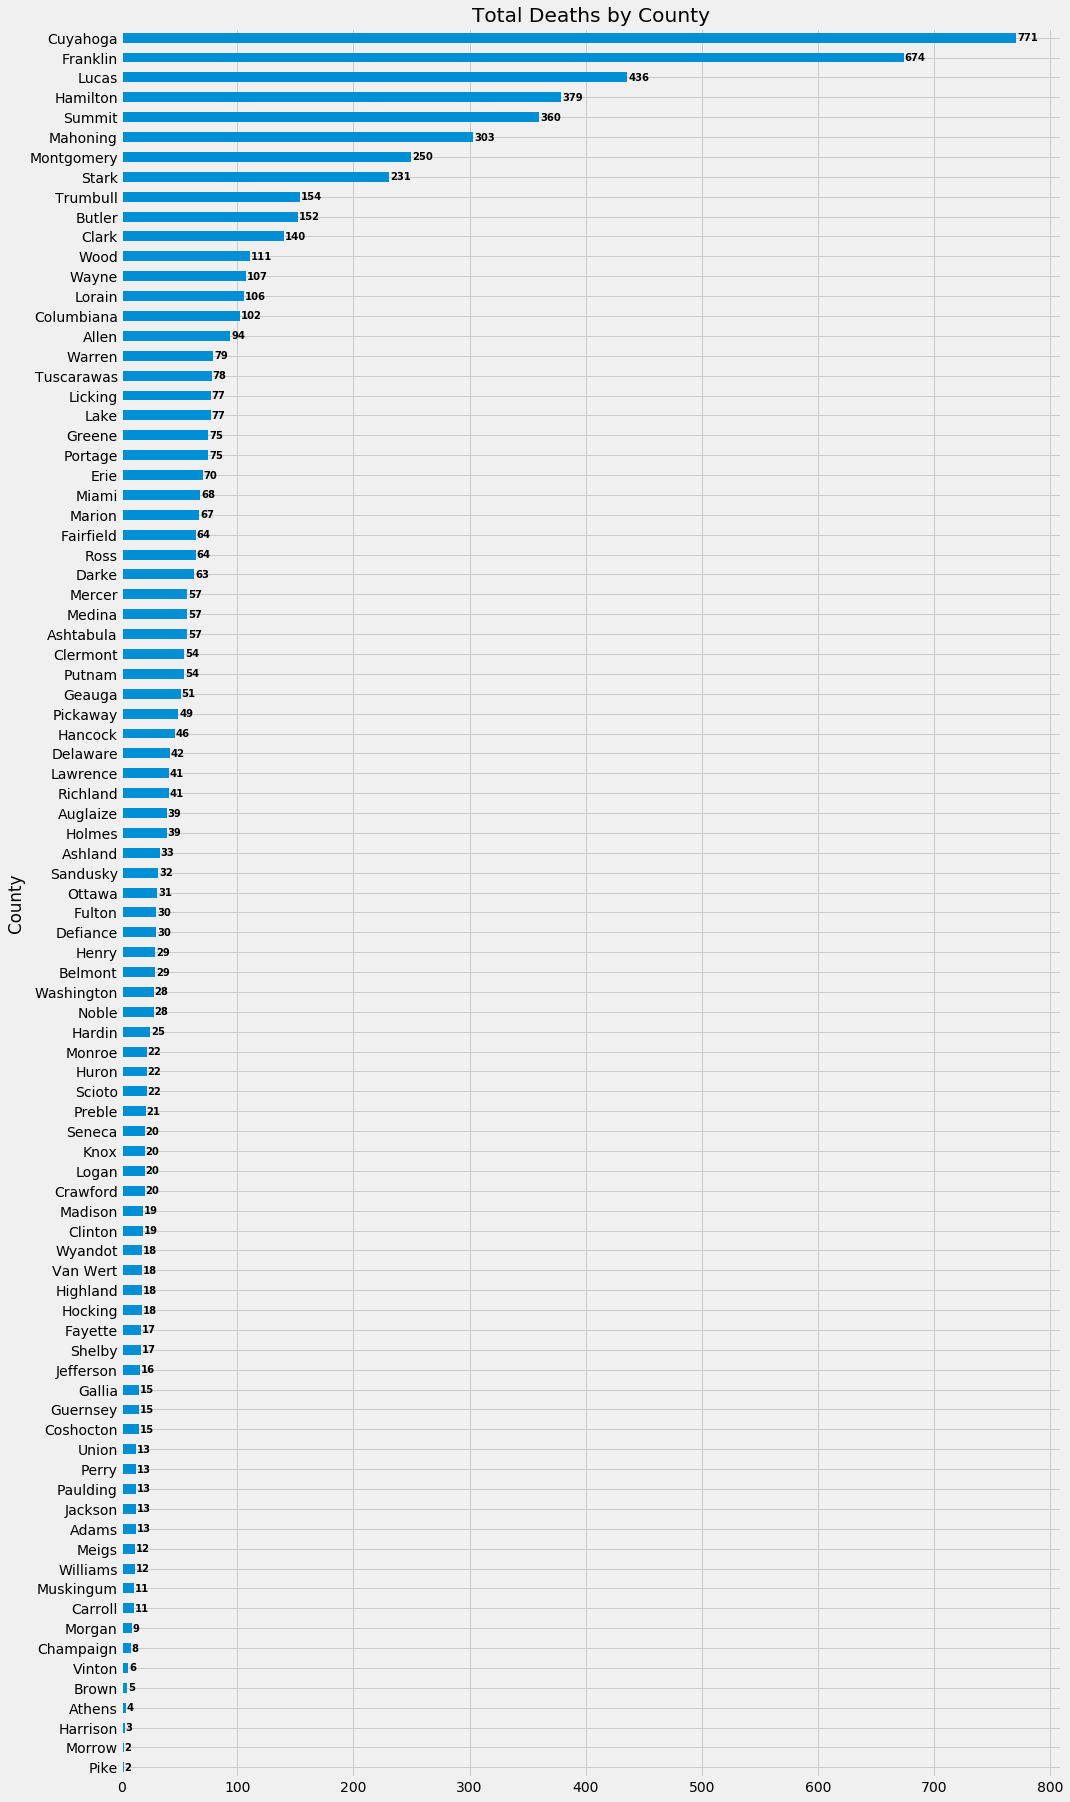

In [21]:
# By County
dfCounty  = df.groupby(["County"]).sum()

dfCounty.sort_values(by=["Death Count"], inplace=True, ascending=True)
ax = dfCounty["Death Count"].plot(kind="barh", figsize=(15,30))

totals = []
# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())
    
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.75, i.get_y()+.1, str(round(i.get_width(), 2)),fontsize=10, fontweight="bold", color='black')


plt.title("Total Deaths by County")
plt.show()

# Rolling Averages
The following section shows rolling averages, which a lot of folks are tracking these days.

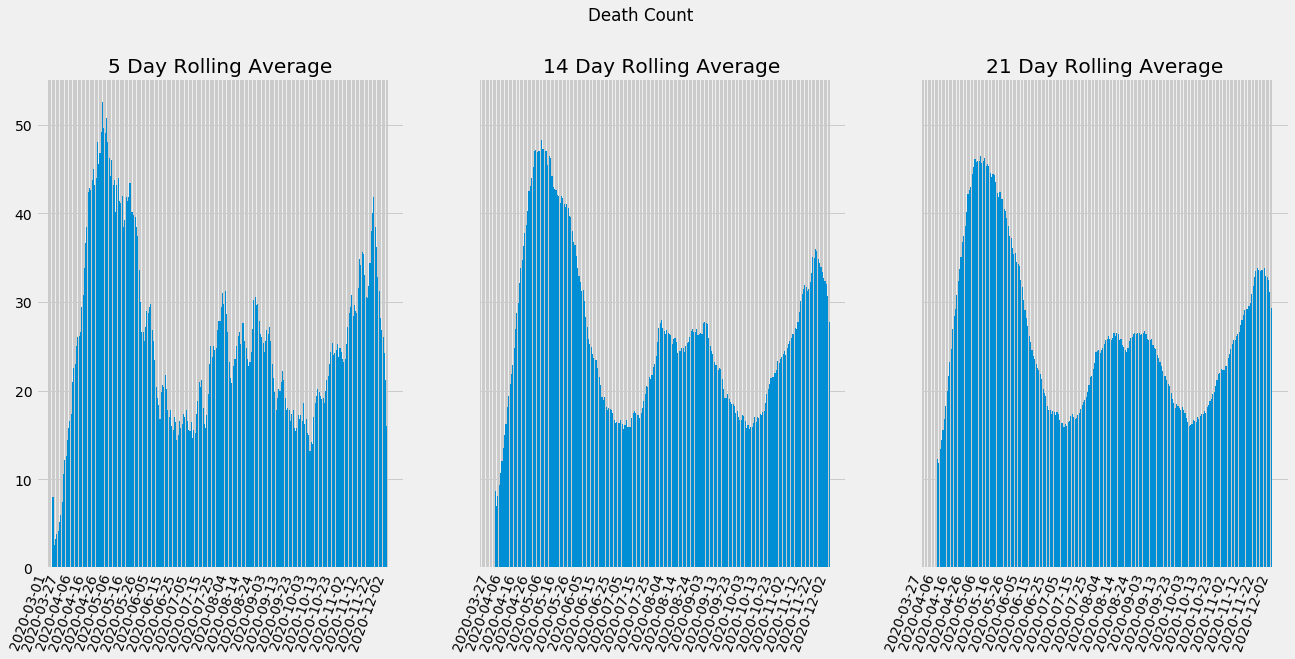

In [22]:
# 5 Day Rolling Averages
h = pd.DataFrame(df.groupby("Date Of Death")["Death Count"].sum())
h["Date of Death"] = h.index
# h.sort_values(by="Date Of Death")

h["Rolling"] = h["Death Count"].rolling(5).mean()
h["Date Of Death"] = h.index.astype(str)

fig, ax = plt.subplots(1, 3, sharey=True, figsize=(20,10))

# ax = sns.catplot(x="Onset Date", y="Rolling", data=h, kind="bar", aspect=25/15)
ax[0].bar(h["Date Of Death"], h["Rolling"])
ax[0].set_title('5 Day Rolling Average')

h["Rolling"] = h["Death Count"].rolling(14).mean()
h["Onset Date"] = h.index.astype(str)

# ax = sns.catplot(x="Onset Date", y="Rolling", data=h, kind="bar", aspect=25/15)
ax[1].bar(h["Date Of Death"], h["Rolling"])
ax[1].set_title('14 Day Rolling Average')

################## 21 Day Rolling Averages
h = pd.DataFrame(df.groupby("Date Of Death")["Death Count"].sum())
# h.sort_values(by="Date Of Death")

h["Rolling"] = h["Death Count"].rolling(21).mean()
h["Date Of Death"] = h.index.astype(str)

# ax = sns.catplot(x="Onset Date", y="Rolling", data=h, kind="bar", aspect=25/15)
ax[2].bar(h["Date Of Death"], h["Rolling"])
ax[2].set_title('21 Day Rolling Average')

fig.autofmt_xdate(rotation=70)
for a in ax:
    for index, label in enumerate(a.xaxis.get_ticklabels()):
        if index % 10 != 0:
            label.set_visible(False)
    t = a.set_yticklabels(['{:,}'.format(int(x)) for x in a.get_yticks().tolist()])
    
fig.suptitle("Death Count")

plt.show()


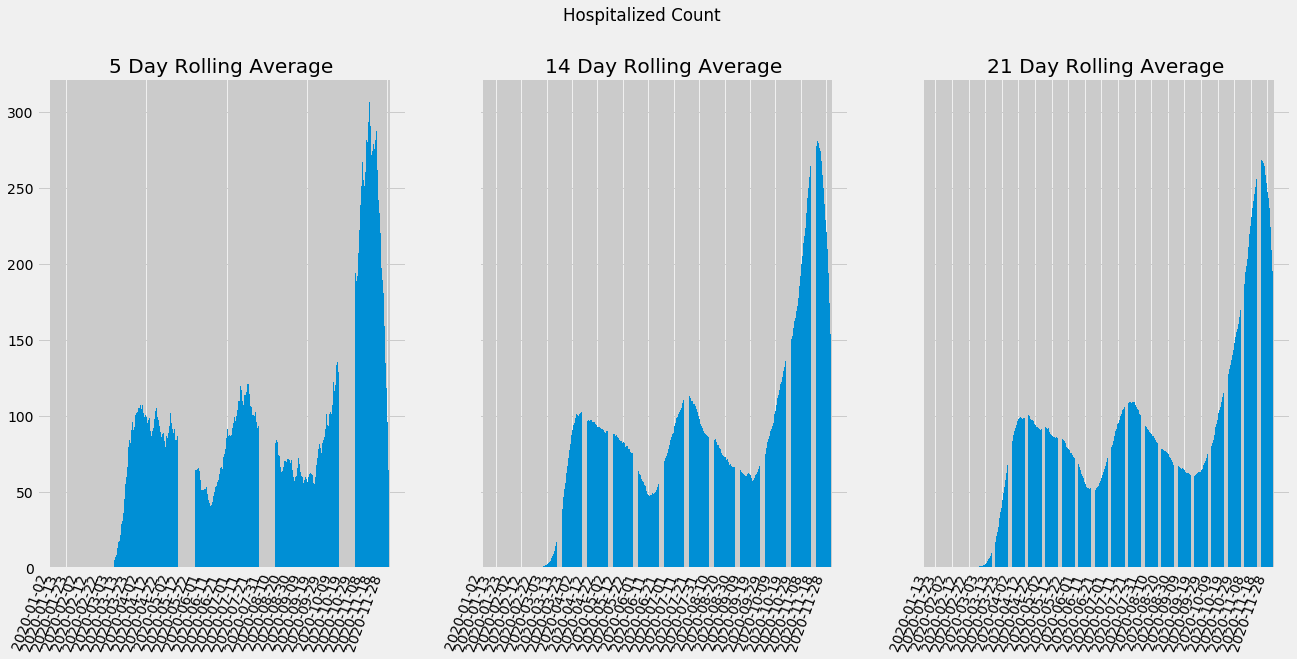

In [23]:
# 5 Day Rolling Averages
h = pd.DataFrame(df.groupby("Onset Date")["Hospitalized Count"].sum())
# h.sort_values(by="Onset Date")

h["Rolling"] = h["Hospitalized Count"].rolling(5).mean()
h["Onset Date"] = h.index.astype(str)

fig, ax = plt.subplots(1, 3, sharey=True, figsize=(20,10))

# ax = sns.catplot(x="Onset Date", y="Rolling", data=h, kind="bar", aspect=25/15)
ax[0].bar(h["Onset Date"], h["Rolling"])
ax[0].set_title('5 Day Rolling Average')

h["Rolling"] = h["Hospitalized Count"].rolling(14).mean()
h["Onset Date"] = h.index.astype(str)

# ax = sns.catplot(x="Onset Date", y="Rolling", data=h, kind="bar", aspect=25/15)
ax[1].bar(h["Onset Date"], h["Rolling"])
ax[1].set_title('14 Day Rolling Average')

################## 21 Day Rolling Averages
h = pd.DataFrame(df.groupby("Onset Date")["Hospitalized Count"].sum())
# h.sort_values(by="Onset Date")

h["Rolling"] = h["Hospitalized Count"].rolling(21).mean()
h["Onset Date"] = h.index.astype(str)

# ax = sns.catplot(x="Onset Date", y="Rolling", data=h, kind="bar", aspect=25/15)
ax[2].bar(h["Onset Date"], h["Rolling"])
ax[2].set_title('21 Day Rolling Average')

fig.autofmt_xdate(rotation=70)
for a in ax:
    for index, label in enumerate(a.xaxis.get_ticklabels()):
        if index % 10 != 0:
            label.set_visible(False)
    t = a.set_yticklabels(['{:,}'.format(int(x)) for x in a.get_yticks().tolist()])
fig.suptitle("Hospitalized Count")

plt.show()

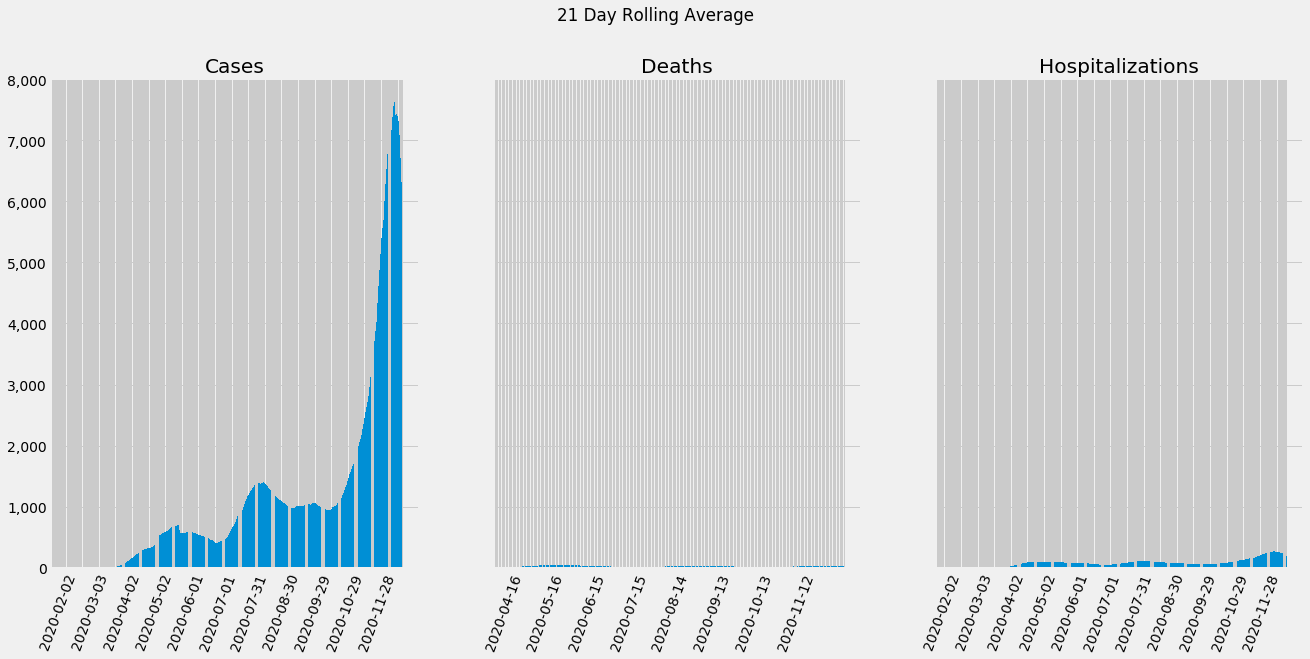

In [24]:
rollingAvg = 21

################## Cases
h = pd.DataFrame(df.groupby("Onset Date")["Case Count"].sum())
# h.sort_values(by="Onset Date")

h["Rolling"] = h["Case Count"].rolling(rollingAvg).mean()
h["Onset Date"] = h.index.astype(str)

fig, ax = plt.subplots(1, 3, sharey=True, figsize=(20,10))

# ax = sns.catplot(x="Onset Date", y="Rolling", data=h, kind="bar", aspect=25/15)
ax[0].bar(h["Onset Date"], h["Rolling"])
ax[0].set_title('Cases')

# fig.autofmt_xdate(rotation=70)
# for a in ax:
#     for index, label in enumerate(a.xaxis.get_ticklabels()):
#         if index % 5 != 0:
#             label.set_visible(False)
#     t = a.set_yticklabels(['{:,}'.format(int(x)) for x in a.get_yticks().tolist()])


################# Deaths
h = pd.DataFrame(df.groupby("Date Of Death")["Death Count"].sum())
# h.sort_values(by="Date Of Death")

h["Rolling"] = h["Death Count"].rolling(rollingAvg).mean()
h["Date Of Death"] = h.index.astype(str)

# ax = sns.catplot(x="Onset Date", y="Rolling", data=h, kind="bar", aspect=25/15)
ax[1].bar(h["Date Of Death"], h["Rolling"])
ax[1].set_title('Deaths')

h = pd.DataFrame(df.groupby("Onset Date")["Hospitalized Count"].sum())
# h.sort_values(by="Onset Date")

h["Rolling"] = h["Hospitalized Count"].rolling(rollingAvg).mean()
h["Onset Date"] = h.index.astype(str)

ax[2].bar(h["Onset Date"], h["Rolling"])
ax[2].set_title('Hospitalizations')

fig.autofmt_xdate(rotation=70)
for a in ax:
    for index, label in enumerate(a.xaxis.get_ticklabels()):
        if index % 30 != 0:
            label.set_visible(False)
    t = a.set_yticklabels(['{:,}'.format(int(x)) for x in a.get_yticks().tolist()])
fig.suptitle("21 Day Rolling Average")


plt.show()

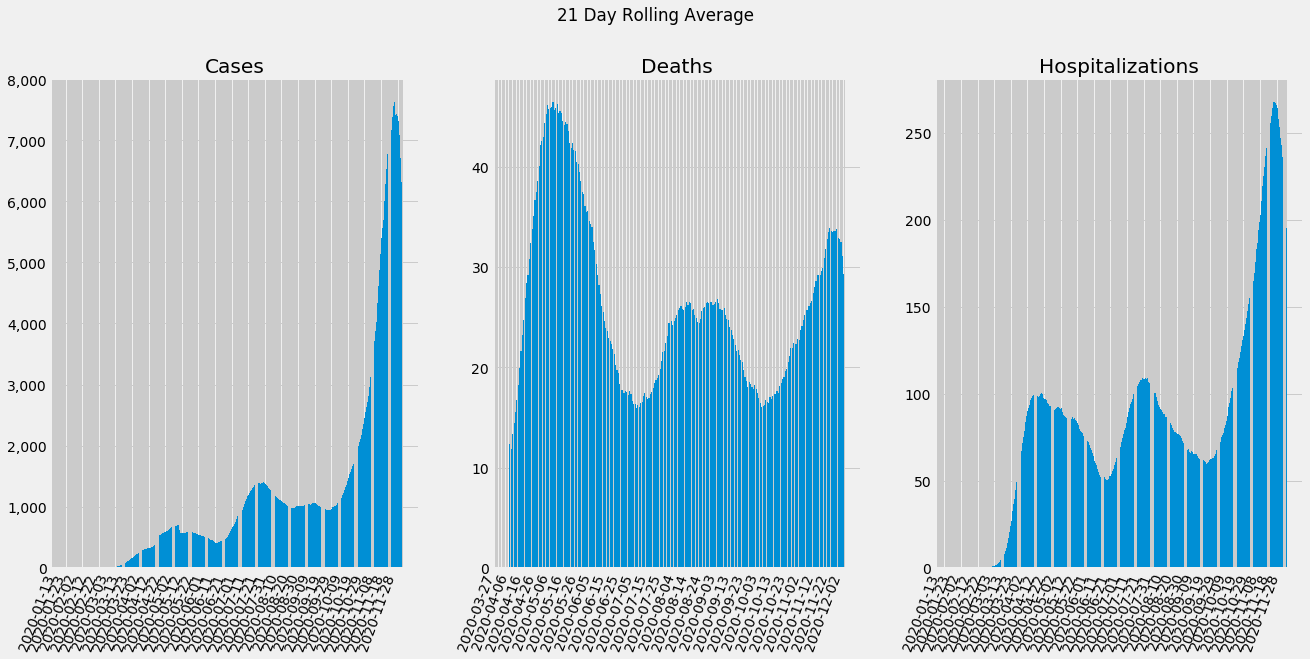

In [25]:
rollingAvg = 21

################## Cases
h = pd.DataFrame(df.groupby("Onset Date")["Case Count"].sum())
# h.sort_values(by="Onset Date")

h["Rolling"] = h["Case Count"].rolling(rollingAvg).mean()
h["Onset Date"] = h.index.astype(str)

fig, ax = plt.subplots(1, 3, sharey=False, figsize=(20,10))

# ax = sns.catplot(x="Onset Date", y="Rolling", data=h, kind="bar", aspect=25/15)
ax[0].bar(h["Onset Date"], h["Rolling"])
ax[0].set_title('Cases')

# fig.autofmt_xdate(rotation=70)
# for a in ax:
#     for index, label in enumerate(a.xaxis.get_ticklabels()):
#         if index % 5 != 0:
#             label.set_visible(False)
#     t = a.set_yticklabels(['{:,}'.format(int(x)) for x in a.get_yticks().tolist()])


################# Deaths
h = pd.DataFrame(df.groupby("Date Of Death")["Death Count"].sum())
# h.sort_values(by="Date Of Death")

h["Rolling"] = h["Death Count"].rolling(rollingAvg).mean()
h["Date Of Death"] = h.index.astype(str)

# ax = sns.catplot(x="Onset Date", y="Rolling", data=h, kind="bar", aspect=25/15)
ax[1].bar(h["Date Of Death"], h["Rolling"])
ax[1].set_title('Deaths')

# fig.autofmt_xdate(rotation=70)
# for a in ax:
#     for index, label in enumerate(a.xaxis.get_ticklabels()):
#         if index % 10 != 0:
#             label.set_visible(False)
#     t = a.set_yticklabels(['{:,}'.format(int(x)) for x in a.get_yticks().tolist()])
    
# fig.suptitle("Death Count")

h = pd.DataFrame(df.groupby("Onset Date")["Hospitalized Count"].sum())
# h.sort_values(by="Onset Date")

h["Rolling"] = h["Hospitalized Count"].rolling(rollingAvg).mean()
h["Onset Date"] = h.index.astype(str)

# ax = sns.catplot(x="Onset Date", y="Rolling", data=h, kind="bar", aspect=25/15)
ax[2].bar(h["Onset Date"], h["Rolling"])
ax[2].set_title('Hospitalizations')

fig.autofmt_xdate(rotation=70)
for a in ax:
    for index, label in enumerate(a.xaxis.get_ticklabels()):
        if index % 10 != 0:
            label.set_visible(False)
    t = a.set_yticklabels(['{:,}'.format(int(x)) for x in a.get_yticks().tolist()])
fig.suptitle("21 Day Rolling Average")


plt.show()

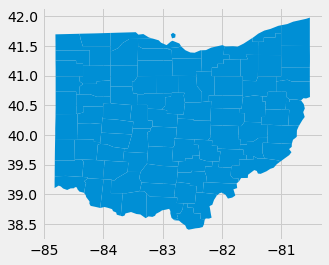

In [26]:
import geopandas as gp

ohioCounties = "OH-39-ohio-counties.json"

mapDf = gp.read_file(ohioCounties)
mapDf.plot()

In [27]:
mapDf.head()

id STATEFP COUNTYFP  COUNTYNS        AFFGEOID  GEOID      NAME LSAD  \
0  None      39      109  01074067  0500000US39109  39109     Miami   06   
1  None      39      135  01074080  0500000US39135  39135    Preble   06   
2  None      39      101  01074063  0500000US39101  39101    Marion   06   
3  None      39      175  01074099  0500000US39175  39175   Wyandot   06   
4  None      39      033  01074029  0500000US39033  39033  Crawford   06   

        ALAND   AWATER                                           geometry  
0  1053028413  7967437  POLYGON ((-84.43317 40.19685, -84.21764 40.200...  
1  1098738402  6065437  POLYGON ((-84.81478 39.72581, -84.81125 39.916...  
2  1045726876   908577  POLYGON ((-83.41909 40.68659, -83.31309 40.687...  
3  1053773792  1783531  POLYGON ((-83.41909 40.99190, -83.11168 40.994...  
4  1040619677  2359515  POLYGON ((-83.11168 40.99439, -82.85551 40.994...

In [28]:
dfCounty = df.groupby(["County"]).sum()
dfCounty

merged = mapDf.merge(dfCounty, right_on='County', left_on='NAME')

merged.head()
merged["center"] = merged["geometry"].centroid
countyNames = merged.copy()
countyNames.set_geometry("center", inplace = True)

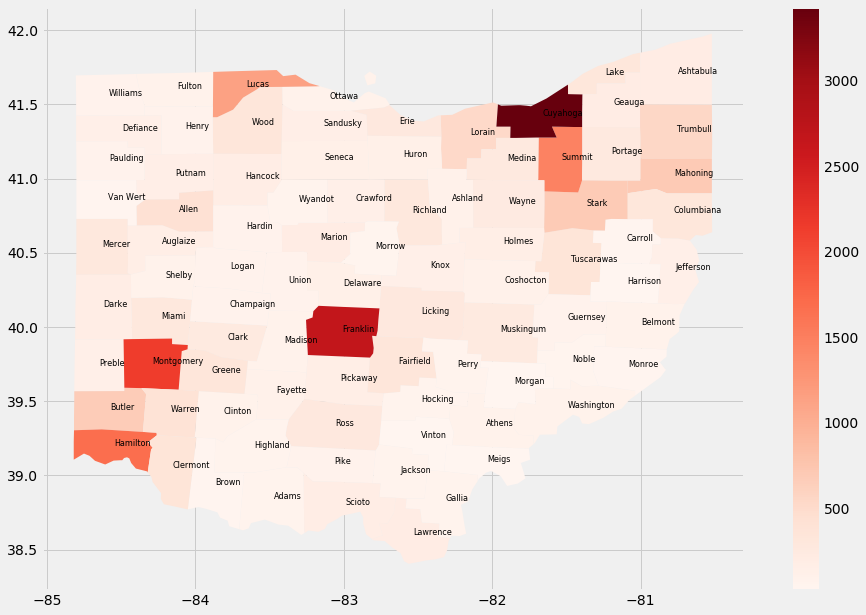

In [29]:
ax = merged.plot(column="Hospitalized Count", legend=True, figsize=(15,10), cmap='Reds')

texts = []
for x, y, label in zip(countyNames.geometry.x, countyNames.geometry.y, countyNames["NAME"]):
    plt.text(x, y, label, fontsize = 8)

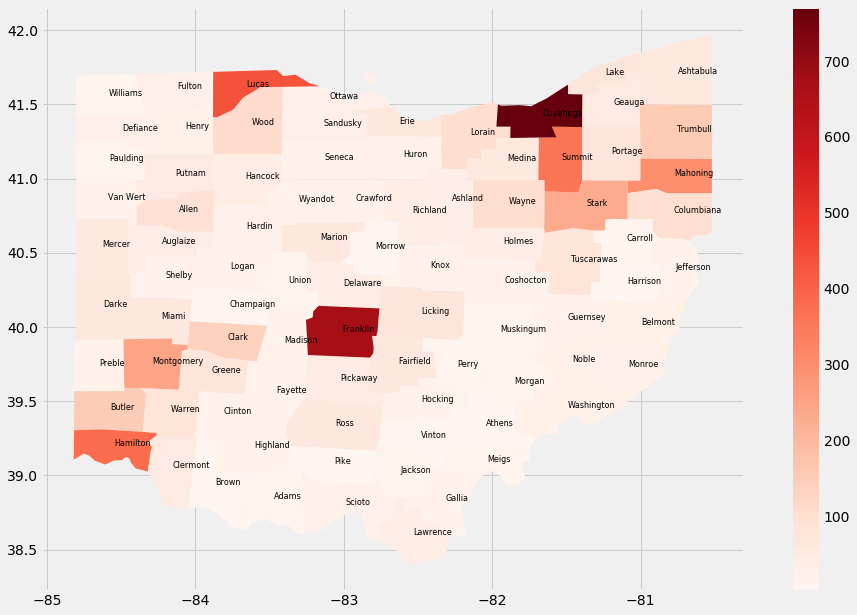

In [30]:
ax = merged.plot(column="Death Count", legend=True, figsize=(15,10), cmap='Reds')

texts = []
for x, y, label in zip(countyNames.geometry.x, countyNames.geometry.y, countyNames["NAME"]):
    plt.text(x, y, label, fontsize = 8)

In [31]:
dfCountyAge  = df.groupby(["County", "Age Range"]).sum()

dfCountyAge

Case Count  Hospitalized Count  Death Count
County  Age Range                                             
Adams   0-19              127                   2            0
        20-29             130                   2            0
        30-39             125                   2            0
        40-49             134                   4            1
        50-59             112                   9            1
...                       ...                 ...          ...
Wyandot 40-49             124                   7            0
        50-59             149                   9            1
        60-69             135                  14            4
        70-79              73                  11            2
        80+                65                  19           11

[765 rows x 3 columns]

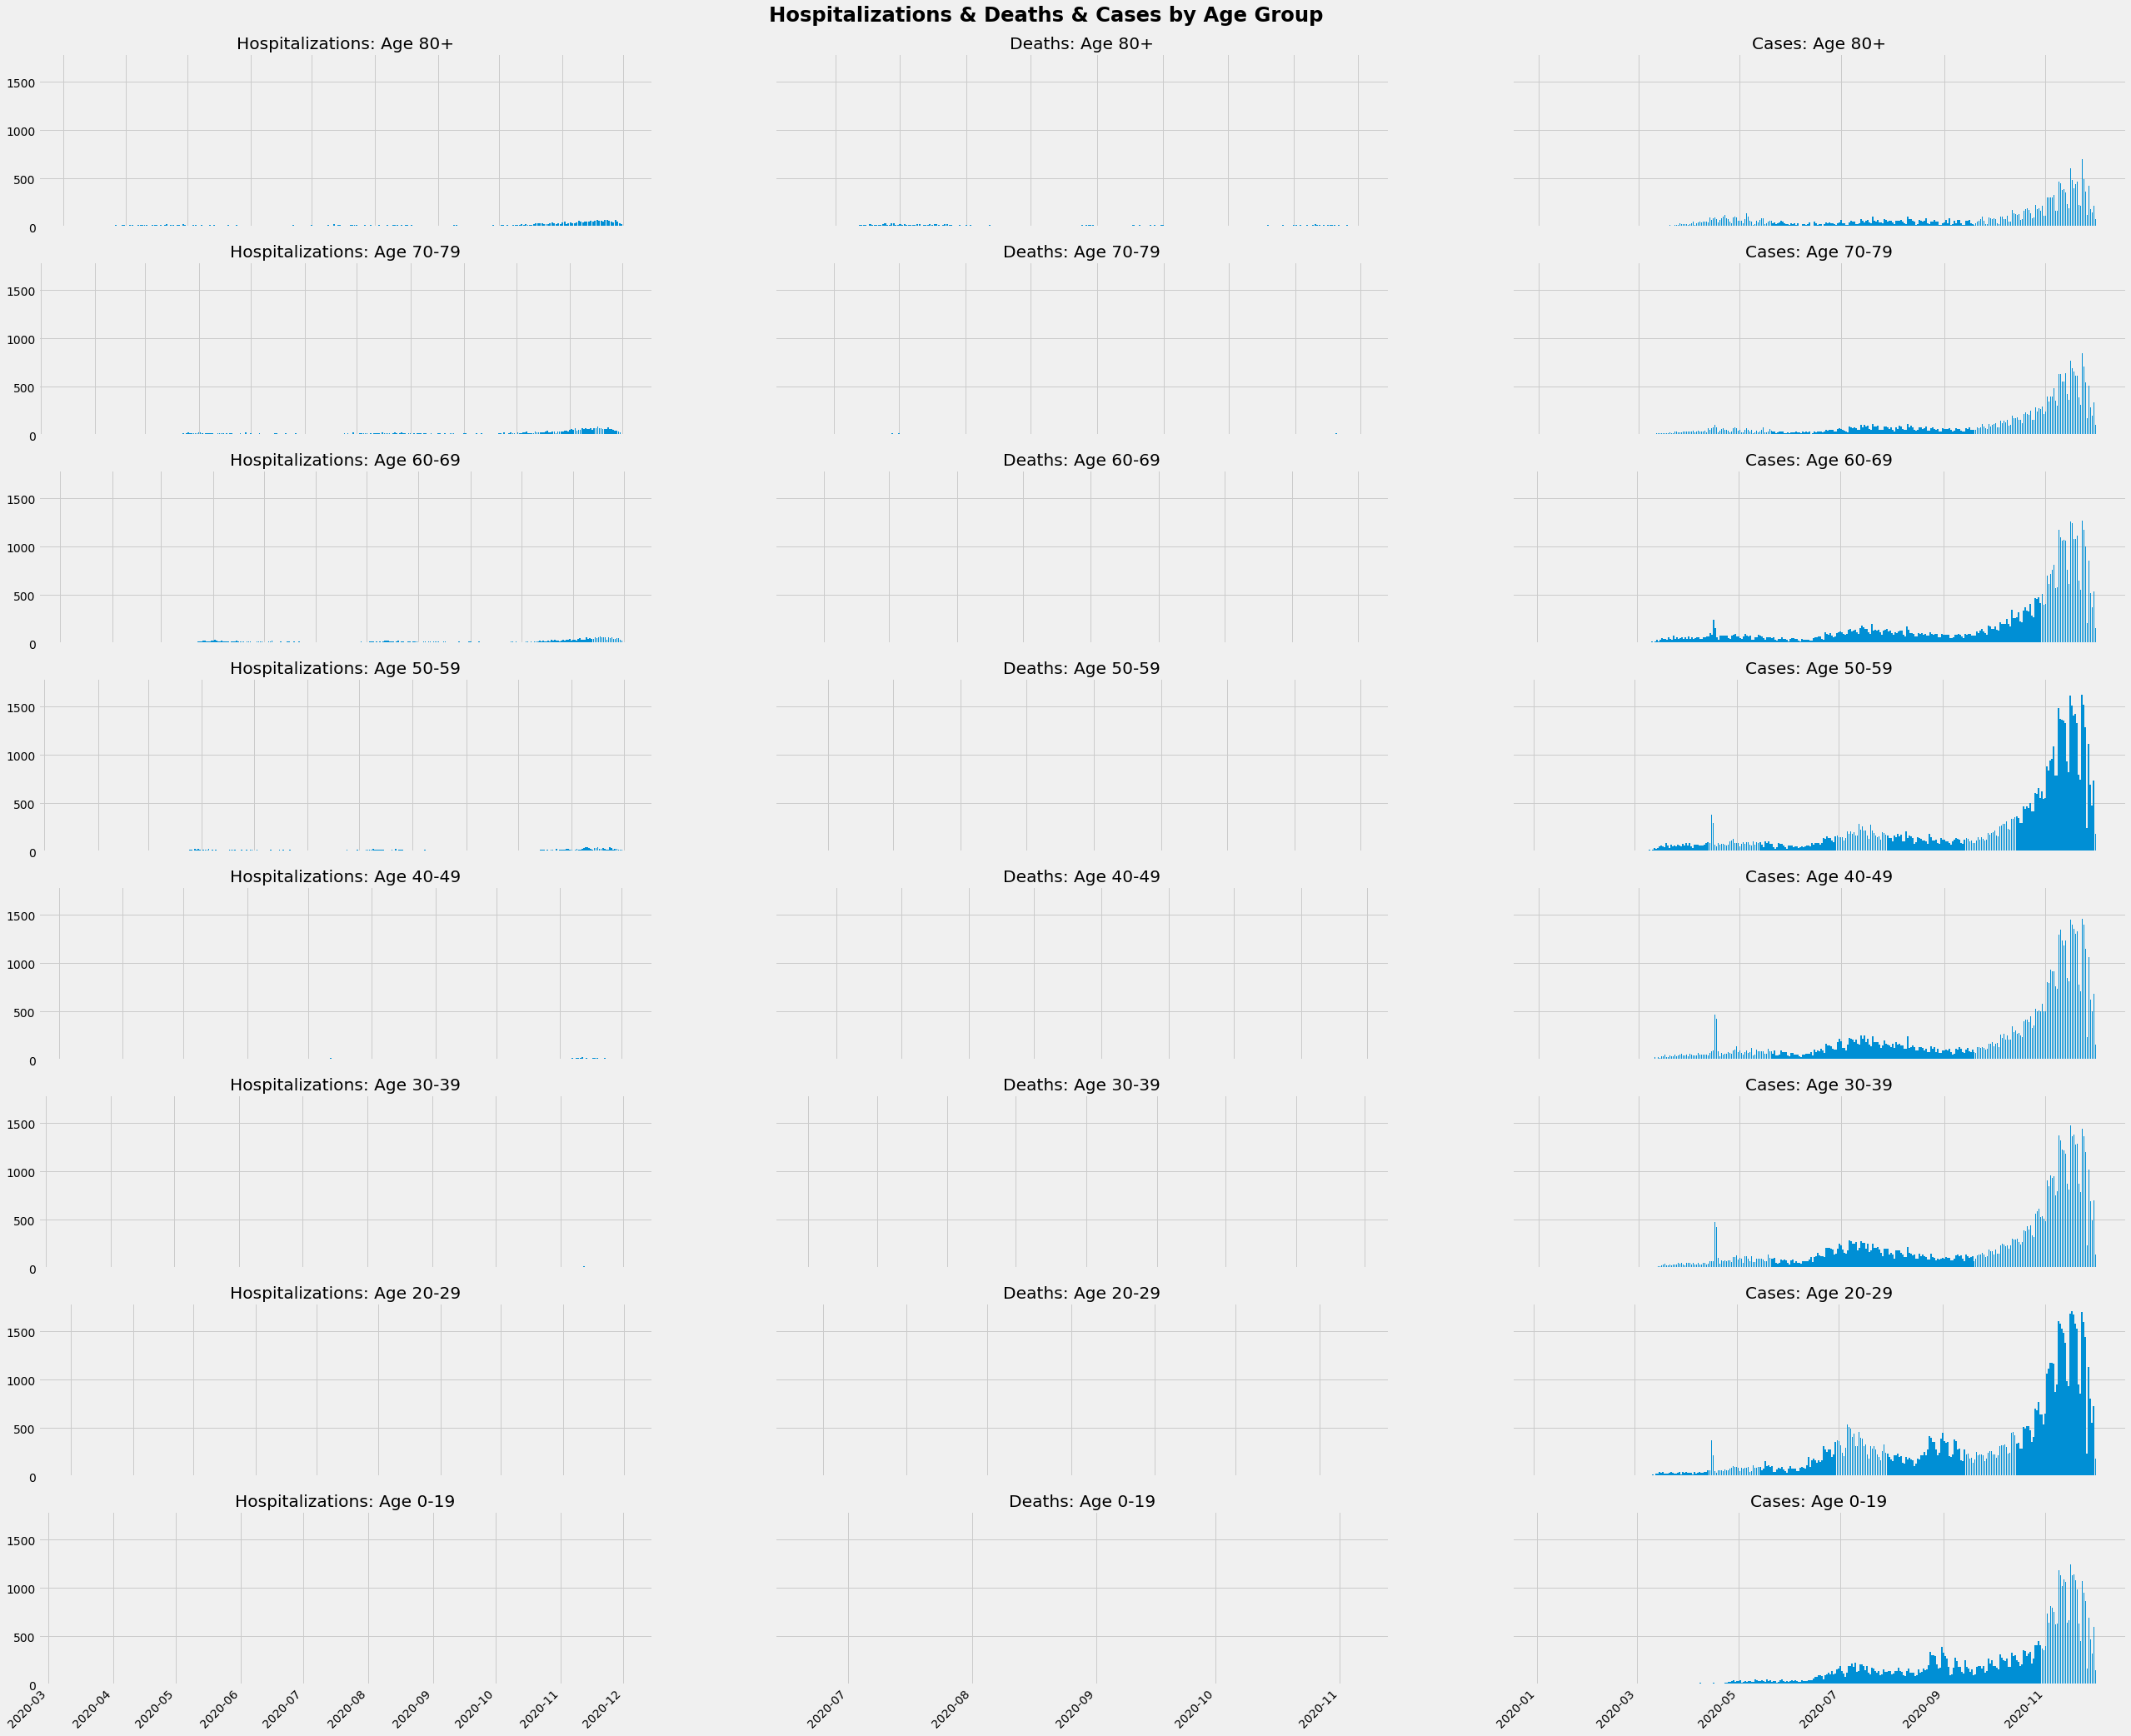

In [32]:
# By Date
localDf = {}

dfHospAgeDate = df.groupby(["Age Range","Admission Date"])
# Admission Date
dfHospAgeDate = dfHospAgeDate.sum().reset_index()

fig, ax = plt.subplots(8, 3, sharey=True, figsize=(40,40))


localDf["80+"] = dfHospAgeDate[(dfHospAgeDate["Age Range"] == "80+") & (dfHospAgeDate["Admission Date"] != "2020/03/01")].sort_values("Admission Date")
ax[0][0].bar(localDf["80+"]["Admission Date"], localDf["80+"]["Hospitalized Count"])
ax[0][0].set_title("Hospitalizations: Age 80+")

localDf["70-79"] = dfHospAgeDate[(dfHospAgeDate["Age Range"] == "70-79") & (dfHospAgeDate["Admission Date"] != "2020/03/01")].sort_values("Admission Date")
ax[1][0].bar(localDf["70-79"]["Admission Date"], localDf["70-79"]["Hospitalized Count"])
ax[1][0].set_title("Hospitalizations: Age 70-79")

localDf["60-69"] = dfHospAgeDate[(dfHospAgeDate["Age Range"] == "60-69") & (dfHospAgeDate["Admission Date"] != "2020/03/01")].sort_values("Admission Date")
ax[2][0].bar(localDf["60-69"]["Admission Date"], localDf["60-69"]["Hospitalized Count"])
ax[2][0].set_title("Hospitalizations: Age 60-69")

localDf["50-59"] = dfHospAgeDate[(dfHospAgeDate["Age Range"] == "50-59") & (dfHospAgeDate["Admission Date"] != "2020/03/01")].sort_values("Admission Date")
ax[3][0].bar(localDf["50-59"]["Admission Date"], localDf["50-59"]["Hospitalized Count"])
ax[3][0].set_title("Hospitalizations: Age 50-59")

localDf["40-49"] = dfHospAgeDate[(dfHospAgeDate["Age Range"] == "40-49") & (dfHospAgeDate["Admission Date"] != "2020/03/01")].sort_values("Admission Date")
ax[4][0].bar(localDf["40-49"]["Admission Date"], localDf["40-49"]["Hospitalized Count"])
ax[4][0].set_title("Hospitalizations: Age 40-49")

localDf["30-39"] = dfHospAgeDate[(dfHospAgeDate["Age Range"] == "30-39") & (dfHospAgeDate["Admission Date"] != "2020/03/01")].sort_values("Admission Date")
ax[5][0].bar(localDf["30-39"]["Admission Date"], localDf["30-39"]["Hospitalized Count"])
ax[5][0].set_title("Hospitalizations: Age 30-39")

localDf["20-29"] = dfHospAgeDate[(dfHospAgeDate["Age Range"] == "20-29") & (dfHospAgeDate["Admission Date"] != "2020/03/01")].sort_values("Admission Date")
ax[7][0].bar(localDf["20-29"]["Admission Date"], localDf["20-29"]["Hospitalized Count"])
ax[6][0].set_title("Hospitalizations: Age 20-29")

localDf["0-19"] = dfHospAgeDate[(dfHospAgeDate["Age Range"] == "0-19") & (dfHospAgeDate["Admission Date"] != "2020/03/01")].sort_values("Admission Date")
ax[6][0].bar(localDf["0-19"]["Admission Date"], localDf["0-19"]["Hospitalized Count"])
ax[7][0].set_title("Hospitalizations: Age 0-19")

# Deaths
dfDeathAgeDate = df.groupby(["Age Range","Date Of Death"])
dfDeathAgeDate = dfDeathAgeDate.sum().reset_index()

localDeathDf = {}
localDeathDf["80+"] = dfDeathAgeDate[(dfDeathAgeDate["Age Range"] == "80+") & (dfDeathAgeDate["Date Of Death"] != "2020/03/01")].sort_values("Date Of Death")
ax[0][1].bar(localDeathDf["80+"]["Date Of Death"], localDeathDf["80+"]["Death Count"])
ax[0][1].set_title("Deaths: Age 80+")

localDeathDf["70-79"] = dfDeathAgeDate[(dfDeathAgeDate["Age Range"] == "70-79") & (dfDeathAgeDate["Date Of Death"] != "2020/03/01")].sort_values("Date Of Death")
ax[1][1].bar(localDeathDf["70-79"]["Date Of Death"], localDeathDf["70-79"]["Death Count"])
ax[1][1].set_title("Deaths: Age 70-79")

localDeathDf["60-69"] = dfDeathAgeDate[(dfDeathAgeDate["Age Range"] == "60-69") & (dfDeathAgeDate["Date Of Death"] != "2020/03/01")].sort_values("Date Of Death")
ax[2][1].bar(localDeathDf["60-69"]["Date Of Death"], localDeathDf["60-69"]["Death Count"])
ax[2][1].set_title("Deaths: Age 60-69")

localDeathDf["50-59"] = dfDeathAgeDate[(dfDeathAgeDate["Age Range"] == "50-59") & (dfDeathAgeDate["Date Of Death"] != "2020/03/01")].sort_values("Date Of Death")
ax[3][1].bar(localDeathDf["50-59"]["Date Of Death"], localDeathDf["50-59"]["Death Count"])
ax[3][1].set_title("Deaths: Age 50-59")

localDeathDf["40-49"] = dfDeathAgeDate[(dfDeathAgeDate["Age Range"] == "40-49") & (dfDeathAgeDate["Date Of Death"] != "2020/03/01")].sort_values("Date Of Death")
ax[4][1].bar(localDeathDf["40-49"]["Date Of Death"], localDeathDf["40-49"]["Death Count"])
ax[4][1].set_title("Deaths: Age 40-49")

localDeathDf["30-39"] = dfDeathAgeDate[(dfDeathAgeDate["Age Range"] == "30-39") & (dfDeathAgeDate["Date Of Death"] != "2020/03/01")].sort_values("Date Of Death")
ax[5][1].bar(localDeathDf["30-39"]["Date Of Death"], localDeathDf["30-39"]["Death Count"])
ax[5][1].set_title("Deaths: Age 30-39")

localDeathDf["20-29"] = dfDeathAgeDate[(dfDeathAgeDate["Age Range"] == "20-29") & (dfDeathAgeDate["Date Of Death"] != "2020/03/01")].sort_values("Date Of Death")
ax[6][1].bar(localDeathDf["20-29"]["Date Of Death"], localDeathDf["20-29"]["Death Count"])
ax[6][1].set_title("Deaths: Age 20-29")

localDeathDf["0-19"] = dfDeathAgeDate[(dfDeathAgeDate["Age Range"] == "0-19") & (dfDeathAgeDate["Date Of Death"] != "2020/03/01")].sort_values("Date Of Death")
ax[7][1].bar(localDeathDf["0-19"]["Date Of Death"], localDeathDf["0-19"]["Death Count"])
ax[7][1].set_title("Deaths: Age 0-19")

# Cases
dfCaseAgeDate = df.groupby(["Age Range","Onset Date"])
dfCaseAgeDate = dfCaseAgeDate.sum().reset_index()

localCaseDf = {}
localCaseDf["80+"] = dfCaseAgeDate[(dfCaseAgeDate["Age Range"] == "80+") & (dfCaseAgeDate["Onset Date"] != "2020/03/01")].sort_values("Onset Date")
ax[0][2].bar(localCaseDf["80+"]["Onset Date"], localCaseDf["80+"]["Case Count"])
ax[0][2].set_title("Cases: Age 80+")

localCaseDf["70-79"] = dfCaseAgeDate[(dfCaseAgeDate["Age Range"] == "70-79") & (dfCaseAgeDate["Onset Date"] != "2020/03/01")].sort_values("Onset Date")
ax[1][2].bar(localCaseDf["70-79"]["Onset Date"], localCaseDf["70-79"]["Case Count"])
ax[1][2].set_title("Cases: Age 70-79")

localCaseDf["60-69"] = dfCaseAgeDate[(dfCaseAgeDate["Age Range"] == "60-69") & (dfCaseAgeDate["Onset Date"] != "2020/03/01")].sort_values("Onset Date")
ax[2][2].bar(localCaseDf["60-69"]["Onset Date"], localCaseDf["60-69"]["Case Count"])
ax[2][2].set_title("Cases: Age 60-69")

localCaseDf["50-59"] = dfCaseAgeDate[(dfCaseAgeDate["Age Range"] == "50-59") & (dfCaseAgeDate["Onset Date"] != "2020/03/01")].sort_values("Onset Date")
ax[3][2].bar(localCaseDf["50-59"]["Onset Date"], localCaseDf["50-59"]["Case Count"])
ax[3][2].set_title("Cases: Age 50-59")

localCaseDf["40-49"] = dfCaseAgeDate[(dfCaseAgeDate["Age Range"] == "40-49") & (dfCaseAgeDate["Onset Date"] != "2020/03/01")].sort_values("Onset Date")
ax[4][2].bar(localCaseDf["40-49"]["Onset Date"], localCaseDf["40-49"]["Case Count"])
ax[4][2].set_title("Cases: Age 40-49")

localCaseDf["30-39"] = dfCaseAgeDate[(dfCaseAgeDate["Age Range"] == "30-39") & (dfCaseAgeDate["Onset Date"] != "2020/03/01")].sort_values("Onset Date")
ax[5][2].bar(localCaseDf["30-39"]["Onset Date"], localCaseDf["30-39"]["Case Count"])
ax[5][2].set_title("Cases: Age 30-39")

localCaseDf["20-29"] = dfCaseAgeDate[(dfCaseAgeDate["Age Range"] == "20-29") & (dfCaseAgeDate["Onset Date"] != "2020/03/01")].sort_values("Onset Date")
ax[6][2].bar(localCaseDf["20-29"]["Onset Date"], localCaseDf["20-29"]["Case Count"])
ax[6][2].set_title("Cases: Age 20-29")

localCaseDf["0-19"] = dfCaseAgeDate[(dfCaseAgeDate["Age Range"] == "0-19") & (dfCaseAgeDate["Onset Date"] != "2020/03/01")].sort_values("Onset Date")
ax[7][2].bar(localCaseDf["0-19"]["Onset Date"], localCaseDf["0-19"]["Case Count"])
ax[7][2].set_title("Cases: Age 0-19")

fig.suptitle("Hospitalizations & Deaths & Cases by Age Group", y=.9, fontsize="xx-large", fontweight="bold")
fig.autofmt_xdate(rotation=45)
plt.show()

fig.savefig("Hosp_Case_Death.png")


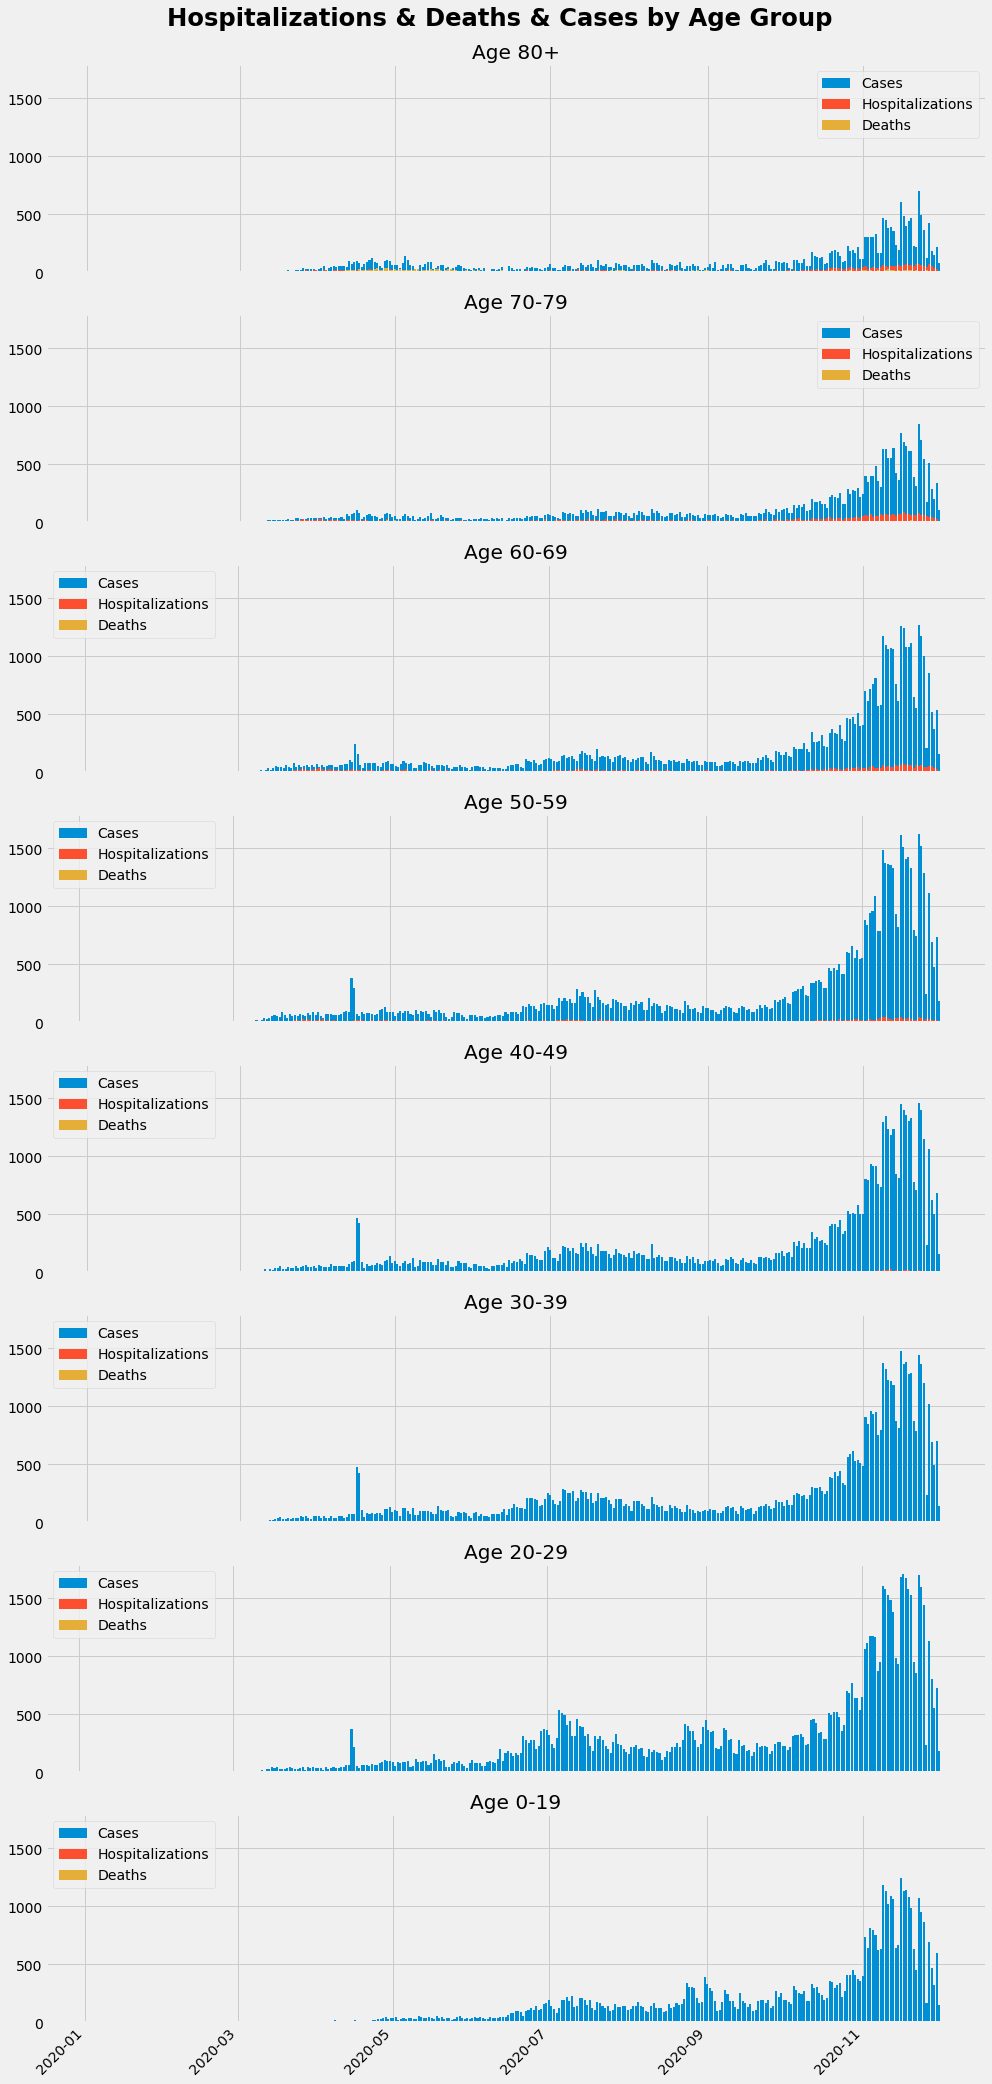

In [33]:
# By Date
localDf = {}
localDeathDf = {}
localCaseDf = {}

# Hospitalizations
dfHospAgeDate = df.groupby(["Age Range","Admission Date"])
dfHospAgeDate = dfHospAgeDate.sum().reset_index()

# Deaths
dfDeathAgeDate = df.groupby(["Age Range","Date Of Death"])
dfDeathAgeDate = dfDeathAgeDate.sum().reset_index()

# Cases
dfCaseAgeDate = df.groupby(["Age Range","Onset Date"])
dfCaseAgeDate = dfCaseAgeDate.sum().reset_index()


fig, ax = plt.subplots(8, 1, sharey=True, figsize=(15,40))


ageRange = "80+"
localAxis = 0
localCaseDf[ageRange] = dfCaseAgeDate[(dfCaseAgeDate["Age Range"] == ageRange) & (dfCaseAgeDate["Onset Date"] != "2020/03/01")].sort_values("Onset Date")
ax[localAxis].bar(localCaseDf[ageRange]["Onset Date"], localCaseDf[ageRange]["Case Count"], label="Cases")

localDf[ageRange] = dfHospAgeDate[(dfHospAgeDate["Age Range"] == ageRange) & (dfHospAgeDate["Admission Date"] != "2020/03/01")].sort_values("Admission Date")
ax[localAxis].bar(localDf[ageRange]["Admission Date"], localDf[ageRange]["Hospitalized Count"], label="Hospitalizations")

localDeathDf[ageRange] = dfDeathAgeDate[(dfDeathAgeDate["Age Range"] == ageRange) & (dfDeathAgeDate["Date Of Death"] != "2020/03/01")].sort_values("Date Of Death")
ax[localAxis].bar(localDeathDf[ageRange]["Date Of Death"], localDeathDf[ageRange]["Death Count"], label="Deaths")
ax[localAxis].set_title("Age " + ageRange)
ax[localAxis].legend()

ageRange = "70-79"
localAxis = 1
localCaseDf[ageRange] = dfCaseAgeDate[(dfCaseAgeDate["Age Range"] == ageRange) & (dfCaseAgeDate["Onset Date"] != "2020/03/01")].sort_values("Onset Date")
ax[localAxis].bar(localCaseDf[ageRange]["Onset Date"], localCaseDf[ageRange]["Case Count"], label="Cases")

localDf[ageRange] = dfHospAgeDate[(dfHospAgeDate["Age Range"] == ageRange) & (dfHospAgeDate["Admission Date"] != "2020/03/01")].sort_values("Admission Date")
ax[localAxis].bar(localDf[ageRange]["Admission Date"], localDf[ageRange]["Hospitalized Count"], label="Hospitalizations")

localDeathDf[ageRange] = dfDeathAgeDate[(dfDeathAgeDate["Age Range"] == ageRange) & (dfDeathAgeDate["Date Of Death"] != "2020/03/01")].sort_values("Date Of Death")
ax[localAxis].bar(localDeathDf[ageRange]["Date Of Death"], localDeathDf[ageRange]["Death Count"], label="Deaths")
ax[localAxis].set_title("Age " + ageRange)
ax[localAxis].legend()

ageRange = "60-69"
localAxis = 2
localCaseDf[ageRange] = dfCaseAgeDate[(dfCaseAgeDate["Age Range"] == ageRange) & (dfCaseAgeDate["Onset Date"] != "2020/03/01")].sort_values("Onset Date")
ax[localAxis].bar(localCaseDf[ageRange]["Onset Date"], localCaseDf[ageRange]["Case Count"], label="Cases")

localDf[ageRange] = dfHospAgeDate[(dfHospAgeDate["Age Range"] == ageRange) & (dfHospAgeDate["Admission Date"] != "2020/03/01")].sort_values("Admission Date")
ax[localAxis].bar(localDf[ageRange]["Admission Date"], localDf[ageRange]["Hospitalized Count"], label="Hospitalizations")

localDeathDf[ageRange] = dfDeathAgeDate[(dfDeathAgeDate["Age Range"] == ageRange) & (dfDeathAgeDate["Date Of Death"] != "2020/03/01")].sort_values("Date Of Death")
ax[localAxis].bar(localDeathDf[ageRange]["Date Of Death"], localDeathDf[ageRange]["Death Count"], label="Deaths")
ax[localAxis].set_title("Age " + ageRange)
ax[localAxis].legend()

ageRange = "50-59"
localAxis = 3
localCaseDf[ageRange] = dfCaseAgeDate[(dfCaseAgeDate["Age Range"] == ageRange) & (dfCaseAgeDate["Onset Date"] != "2020/03/01")].sort_values("Onset Date")
ax[localAxis].bar(localCaseDf[ageRange]["Onset Date"], localCaseDf[ageRange]["Case Count"], label="Cases")

localDf[ageRange] = dfHospAgeDate[(dfHospAgeDate["Age Range"] == ageRange) & (dfHospAgeDate["Admission Date"] != "2020/03/01")].sort_values("Admission Date")
ax[localAxis].bar(localDf[ageRange]["Admission Date"], localDf[ageRange]["Hospitalized Count"], label="Hospitalizations")

localDeathDf[ageRange] = dfDeathAgeDate[(dfDeathAgeDate["Age Range"] == ageRange) & (dfDeathAgeDate["Date Of Death"] != "2020/03/01")].sort_values("Date Of Death")
ax[localAxis].bar(localDeathDf[ageRange]["Date Of Death"], localDeathDf[ageRange]["Death Count"], label="Deaths")
ax[localAxis].set_title("Age " + ageRange)
ax[localAxis].legend()

ageRange = "40-49"
localAxis = 4
localCaseDf[ageRange] = dfCaseAgeDate[(dfCaseAgeDate["Age Range"] == ageRange) & (dfCaseAgeDate["Onset Date"] != "2020/03/01")].sort_values("Onset Date")
ax[localAxis].bar(localCaseDf[ageRange]["Onset Date"], localCaseDf[ageRange]["Case Count"], label="Cases")

localDf[ageRange] = dfHospAgeDate[(dfHospAgeDate["Age Range"] == ageRange) & (dfHospAgeDate["Admission Date"] != "2020/03/01")].sort_values("Admission Date")
ax[localAxis].bar(localDf[ageRange]["Admission Date"], localDf[ageRange]["Hospitalized Count"], label="Hospitalizations")

localDeathDf[ageRange] = dfDeathAgeDate[(dfDeathAgeDate["Age Range"] == ageRange) & (dfDeathAgeDate["Date Of Death"] != "2020/03/01")].sort_values("Date Of Death")
ax[localAxis].bar(localDeathDf[ageRange]["Date Of Death"], localDeathDf[ageRange]["Death Count"], label="Deaths")
ax[localAxis].set_title("Age " + ageRange)
ax[localAxis].legend()

ageRange = "30-39"
localAxis = 5
localCaseDf[ageRange] = dfCaseAgeDate[(dfCaseAgeDate["Age Range"] == ageRange) & (dfCaseAgeDate["Onset Date"] != "2020/03/01")].sort_values("Onset Date")
ax[localAxis].bar(localCaseDf[ageRange]["Onset Date"], localCaseDf[ageRange]["Case Count"], label="Cases")

localDf[ageRange] = dfHospAgeDate[(dfHospAgeDate["Age Range"] == ageRange) & (dfHospAgeDate["Admission Date"] != "2020/03/01")].sort_values("Admission Date")
ax[localAxis].bar(localDf[ageRange]["Admission Date"], localDf[ageRange]["Hospitalized Count"], label="Hospitalizations")

localDeathDf[ageRange] = dfDeathAgeDate[(dfDeathAgeDate["Age Range"] == ageRange) & (dfDeathAgeDate["Date Of Death"] != "2020/03/01")].sort_values("Date Of Death")
ax[localAxis].bar(localDeathDf[ageRange]["Date Of Death"], localDeathDf[ageRange]["Death Count"], label="Deaths")
ax[localAxis].set_title("Age " + ageRange)
ax[localAxis].legend()

ageRange = "20-29"
localAxis = 6
localCaseDf[ageRange] = dfCaseAgeDate[(dfCaseAgeDate["Age Range"] == ageRange) & (dfCaseAgeDate["Onset Date"] != "2020/03/01")].sort_values("Onset Date")
ax[localAxis].bar(localCaseDf[ageRange]["Onset Date"], localCaseDf[ageRange]["Case Count"], label="Cases")

localDf[ageRange] = dfHospAgeDate[(dfHospAgeDate["Age Range"] == ageRange) & (dfHospAgeDate["Admission Date"] != "2020/03/01")].sort_values("Admission Date")
ax[localAxis].bar(localDf[ageRange]["Admission Date"], localDf[ageRange]["Hospitalized Count"], label="Hospitalizations")

localDeathDf[ageRange] = dfDeathAgeDate[(dfDeathAgeDate["Age Range"] == ageRange) & (dfDeathAgeDate["Date Of Death"] != "2020/03/01")].sort_values("Date Of Death")
ax[localAxis].bar(localDeathDf[ageRange]["Date Of Death"], localDeathDf[ageRange]["Death Count"], label="Deaths")
ax[localAxis].set_title("Age " + ageRange)
ax[localAxis].legend()

ageRange = "0-19"
localAxis = 7
localCaseDf[ageRange] = dfCaseAgeDate[(dfCaseAgeDate["Age Range"] == ageRange) & (dfCaseAgeDate["Onset Date"] != "2020/03/01")].sort_values("Onset Date")
ax[localAxis].bar(localCaseDf[ageRange]["Onset Date"], localCaseDf[ageRange]["Case Count"], label="Cases")

localDf[ageRange] = dfHospAgeDate[(dfHospAgeDate["Age Range"] == ageRange) & (dfHospAgeDate["Admission Date"] != "2020/03/01")].sort_values("Admission Date")
ax[localAxis].bar(localDf[ageRange]["Admission Date"], localDf[ageRange]["Hospitalized Count"], label="Hospitalizations")

localDeathDf[ageRange] = dfDeathAgeDate[(dfDeathAgeDate["Age Range"] == ageRange) & (dfDeathAgeDate["Date Of Death"] != "2020/03/01")].sort_values("Date Of Death")
ax[localAxis].bar(localDeathDf[ageRange]["Date Of Death"], localDeathDf[ageRange]["Death Count"], label="Deaths")
ax[localAxis].set_title("Age " + ageRange)
ax[localAxis].legend()


fig.suptitle("Hospitalizations & Deaths & Cases by Age Group", y=.9, fontsize="xx-large", fontweight="bold")
fig.autofmt_xdate(rotation=45)
plt.show()

fig.savefig("Hosp_Case_Death_2.png")


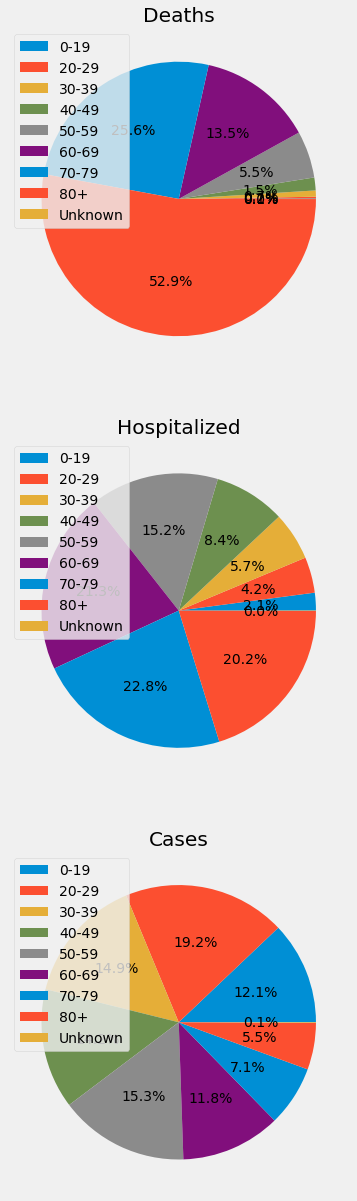

In [34]:
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} g)".format(pct, absolute)


fig, ax = plt.subplots(3, 1, sharey=True, sharex=True, figsize=(15,20))

ax[0].pie(dfAgeTotals["Deaths"], labels=dfAgeTotals.index, labeldistance=None, autopct='%1.1f%%')
ax[0].set_title("Deaths")
ax[0].legend()

ax[1].pie(dfAgeTotals["Hospitalized"], labels=dfAgeTotals.index, labeldistance=None, autopct='%1.1f%%')
ax[1].set_title("Hospitalized")
ax[1].legend()

ax[2].pie(dfAgeTotals["Cases"], labels=dfAgeTotals.index, labeldistance=None, autopct='%1.1f%%')
ax[2].set_title("Cases")
ax[2].legend()

plt.show()

In [35]:
dfAgeTotals

Deaths  Hospitalized  Cases  DeathPerc  HospitalizedPerc  \
Age Range                                                             
0-19            4           583  52936   0.000913          0.133127   
20-29          13          1174  83946   0.002969          0.268081   
30-39          49          1586  65137   0.011189          0.362160   
40-49         101          2346  61999   0.023063          0.535704   
50-59         369          4241  66797   0.084260          0.968424   
60-69         898          5946  51501   0.205057          1.357757   
70-79        1708          6370  31192   0.390018          1.454577   
80+          3528          5627  24043   0.805612          1.284914   
Unknown         1            12    377   0.000228          0.002740   

           CasesPerc  PercTotalDeaths  PercTotalHosps  DeathPercAge  \
Age Range                                                             
0-19       12.087832         0.059961        2.090730      0.007556   
20-29      19.168904         0.194873        4.210149      0.015486   
30-39      14.873906         0.734523        5.687646      0.075226   
40-49      14.157350         1.514016        8.413125      0.162906   
50-59      15.252964         5.531405       15.208894      0.552420   
60-69      11.760152        13.461250       21.323292      1.743655   
70-79       7.122632        25.603358       22.843823      5.475763   
80+         5.490172        52.885624       20.179308     14.673710   
Unknown     0.086087         0.014990        0.043034      0.265252   

           HospitalizedPercAge  Non Severe Case % Age Range  
Age Range                                                    
0-19                  1.101330          98.891114      0-19  
20-29                 1.398518          98.585996     20-29  
30-39                 2.434868          97.489906     30-39  
40-49                 3.783932          96.053162     40-49  
50-59                 6.349088          93.098492     50-59  
60-69                11.545407          86.710938     60-69  
70-79                20.421903          74.102334     70-79  
80+                  23.403901          61.922389       80+  
Unknown               3.183024          96.551724   Unknown

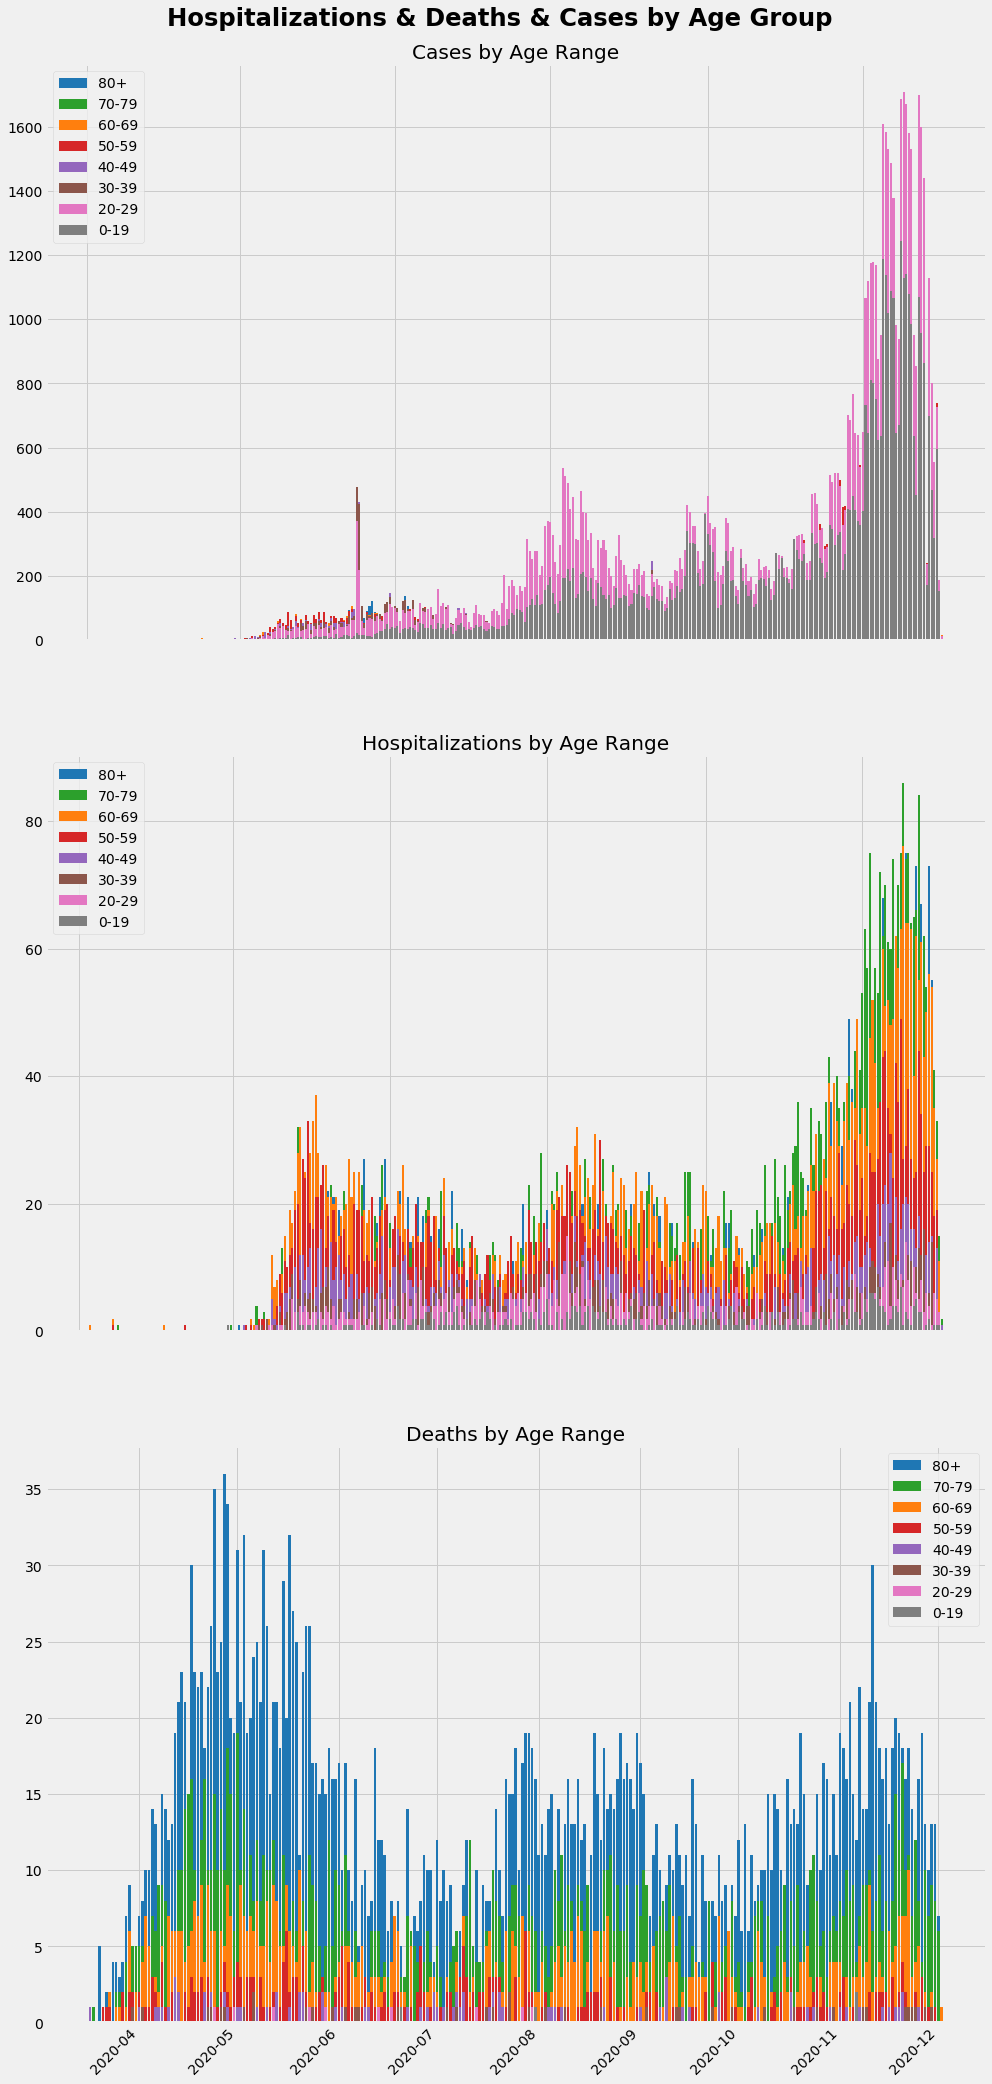

In [36]:
# By Date
localDf = {}
localDeathDf = {}
localCaseDf = {}

# Hospitalizations
dfHospAgeDate = df.groupby(["Age Range","Admission Date"])
dfHospAgeDate = dfHospAgeDate.sum().reset_index()

# Deaths
dfDeathAgeDate = df.groupby(["Age Range","Date Of Death"])
dfDeathAgeDate = dfDeathAgeDate.sum().reset_index()

# Cases
dfCaseAgeDate = df.groupby(["Age Range","Onset Date"])
dfCaseAgeDate = dfCaseAgeDate.sum().reset_index()


fig, ax = plt.subplots(3, 1, sharey=False, figsize=(15,40))

ageRanges = ["80+", "70-79", "60-69", "50-59", "40-49", "30-39", "20-29", "0-19" ]

colors ={
    "80+"  : "tab:blue",
    "70-79": "tab:green",
    "60-69": "tab:orange",
    "50-59": "tab:red",
    "40-49": "tab:purple",
    "30-39": "tab:brown",
    "20-29": "tab:pink",
    "0-19":  "tab:gray"
}

localAxis = 0
for ageRange in ageRanges:
    localCaseDf[ageRange] = dfCaseAgeDate[(dfCaseAgeDate["Age Range"] == ageRange) & (dfCaseAgeDate["Onset Date"] != "2020/03/01")].sort_values("Onset Date")
    ax[localAxis].bar(localCaseDf[ageRange]["Onset Date"], localCaseDf[ageRange]["Case Count"], label=ageRange, color=colors[ageRange])

ax[localAxis].set_title("Cases by Age Range")
ax[localAxis].legend()

localAxis = 1
for ageRange in ageRanges:
    localDf[ageRange] = dfHospAgeDate[(dfHospAgeDate["Age Range"] == ageRange) & (dfHospAgeDate["Admission Date"] != "2020/03/01")].sort_values("Admission Date")
    ax[localAxis].bar(localDf[ageRange]["Admission Date"], localDf[ageRange]["Hospitalized Count"], label=ageRange, color=colors[ageRange])

ax[localAxis].set_title("Hospitalizations by Age Range")
ax[localAxis].legend()

localAxis = 2
for ageRange in ageRanges:
    localDeathDf[ageRange] = dfDeathAgeDate[(dfDeathAgeDate["Age Range"] == ageRange) & (dfDeathAgeDate["Date Of Death"] != "2020/03/01")].sort_values("Date Of Death")
    ax[localAxis].bar(localDeathDf[ageRange]["Date Of Death"], localDeathDf[ageRange]["Death Count"], label=ageRange, color=colors[ageRange])

ax[localAxis].set_title("Deaths by Age Range")
ax[localAxis].legend()
    
fig.suptitle("Hospitalizations & Deaths & Cases by Age Group", y=.9, fontsize="xx-large", fontweight="bold")
fig.autofmt_xdate(rotation=45)
plt.show()

In [37]:
import matplotlib.colors as mcolors

In [38]:
# print(mcolors.TABLEAU_COLORS)

In [40]:
df["CaseMonth"] = df["Onset Date"].dt.month
df["HospMonth"] = df["Admission Date"].dt.month
df["DeathMonth"] = df["Date Of Death"].dt.month

# Hospitalizations
dfHospAgeDate = df.groupby(["Age Range","HospMonth"])
dfHospAgeDate = dfHospAgeDate.sum().reset_index()

# Deaths
dfDeathAgeDate = df.groupby(["Age Range","DeathMonth"])
dfDeathAgeDate = dfDeathAgeDate.sum().reset_index()

# Cases
dfCaseAgeDate = df.groupby(["Age Range","CaseMonth"])
dfCaseAgeDate = dfCaseAgeDate.sum().reset_index()

caseAgeMonth = dfCaseAgeDate.pivot(index="Age Range", columns="CaseMonth")["Case Count"]
hospAgeMonth = dfHospAgeDate.pivot(index="Age Range", columns="HospMonth")["Hospitalized Count"]
deathAgeMonth = dfDeathAgeDate.pivot(index="Age Range", columns="DeathMonth")["Death Count"]

# cols = 
caseAgeMonth.columns = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
caseAgeMonthStyled = caseAgeMonth.style.format({
    'January'  : '{:,}'.format,
    'February' : '{:,}'.format,
    'March'    : '{:,}'.format,
    'March'    : '{:,}'.format,
    'April'    : '{:,}'.format,
    'May'      : '{:,}'.format,
    'June'     : '{:,}'.format,
    'July'     : '{:,}'.format,
    'August'   : '{:,}'.format,
    'September': '{:,}'.format,
    'October'  : '{:,}'.format,
    'November' : '{:,}'.format,
    'December' : '{:,}'.format
})
hospAgeMonth.columns = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
hospAgeMonthStyled = hospAgeMonth.style.format({
    'January'  : '{:,}'.format,
    'February' : '{:,}'.format,
    'March'    : '{:,}'.format,
    'March'    : '{:,}'.format,
    'April'    : '{:,}'.format,
    'May'      : '{:,}'.format,
    'June'     : '{:,}'.format,
    'July'     : '{:,}'.format,
    'August'   : '{:,}'.format,
    'September': '{:,}'.format,
    'October'  : '{:,}'.format,
    'November' : '{:,}'.format,
    'December' : '{:,}'.format
})
deathAgeMonth.columns = ["March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
deathAgeMonthStyled = deathAgeMonth.style.format({
    'January'  : '{:,}'.format,
    'February' : '{:,}'.format,
    'March'    : '{:,}'.format,
    'March'    : '{:,}'.format,
    'April'    : '{:,}'.format,
    'May'      : '{:,}'.format,
    'June'     : '{:,}'.format,
    'July'     : '{:,}'.format,
    'August'   : '{:,}'.format,
    'September': '{:,}'.format,
    'October'  : '{:,}'.format,
    'November' : '{:,}'.format,
    'December' : '{:.}'.format
})
caseAgeMonthStyled

In [ ]:
hospAgeMonthStyled

In [ ]:
deathAgeMonthStyled

In [ ]:
caseAgeMonthPerc = dfCaseAgeDate.pivot(index="Age Range", columns="CaseMonth")["Case Count"]/dfCaseAgeDate.pivot(index="Age Range", columns="CaseMonth")["Case Count"].sum()*100
hospAgeMonthPerc = dfHospAgeDate.pivot(index="Age Range", columns="HospMonth")["Hospitalized Count"]/dfHospAgeDate.pivot(index="Age Range", columns="HospMonth")["Hospitalized Count"].sum()*100
deathAgeMonthPerc = dfDeathAgeDate.pivot(index="Age Range", columns="DeathMonth")["Death Count"]/dfDeathAgeDate.pivot(index="Age Range", columns="DeathMonth")["Death Count"].sum()*100

# cols = 
caseAgeMonthPerc.columns = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November"]
caseAgeMonthPercStyled = caseAgeMonthPerc.style.format({
    'January'  : '{:,.2f} %'.format,
    'February' : '{:,.2f} %'.format,
    'March'    : '{:,.2f} %'.format,
    'March'    : '{:,.2f} %'.format,
    'April'    : '{:,.2f} %'.format,
    'May'      : '{:,.2f} %'.format,
    'June'     : '{:,.2f} %'.format,
    'July'     : '{:,.2f} %'.format,
    'August'   : '{:,.2f} %'.format,
    'September': '{:,.2f} %'.format,
    'October'  : '{:,.2f} %'.format,
    'November' : '{:,.2f} %'.format,
    'December' : '{:,.2f} %'.format
})
hospAgeMonthPerc.columns = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November"]
hospAgeMonthPercStyled = hospAgeMonthPerc.style.format({
    'January'  : '{:,.2f} %'.format,
    'February' : '{:,.2f} %'.format,
    'March'    : '{:,.2f} %'.format,
    'March'    : '{:,.2f} %'.format,
    'April'    : '{:,.2f} %'.format,
    'May'      : '{:,.2f} %'.format,
    'June'     : '{:,.2f} %'.format,
    'July'     : '{:,.2f} %'.format,
    'August'   : '{:,.2f} %'.format,
    'September': '{:,.2f} %'.format,
    'October'  : '{:,.2f} %'.format,
    'November' : '{:,.2f} %'.format,
    'December' : '{:,.2f} %'.format
})
deathAgeMonthPerc.columns = ["March", "April", "May", "June", "July", "August", "September", "October", "November"]
deathAgeMonthPercStyled = deathAgeMonthPerc.style.format({
    'January'  : '{:,.2f} %'.format,
    'February' : '{:,.2f} %'.format,
    'March'    : '{:,.2f} %'.format,
    'March'    : '{:,.2f} %'.format,
    'April'    : '{:,.2f} %'.format,
    'May'      : '{:,.2f} %'.format,
    'June'     : '{:,.2f} %'.format,
    'July'     : '{:,.2f} %'.format,
    'August'   : '{:,.2f} %'.format,
    'September': '{:,.2f} %'.format,
    'October'  : '{:,.2f} %'.format,
    'November' : '{:,.2f} %'.format,
    'December' : '{:,.2f} %'.format
})
caseAgeMonthPerc

caseAgeMonthPerc

In [ ]:
hospAgeMonthPercStyled

In [ ]:
deathAgeMonthPerc

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(15,20))

dfHeat = deathAgeMonthPerc.reset_index().fillna(0)
dfHeat.index = dfHeat["Age Range"]
sns.heatmap(dfHeat.iloc[:,1:], ax=ax[0], annot=True, fmt='.2g')
ax[0].set_title("Deaths")

dfHeat = caseAgeMonthPerc.reset_index().fillna(0)
dfHeat.index = dfHeat["Age Range"]
sns.heatmap(dfHeat.iloc[:,1:], ax=ax[1], annot=True, fmt='.2g')
ax[1].set_title("Cases")

dfHeat = hospAgeMonthPerc.reset_index().fillna(0)
dfHeat.index = dfHeat["Age Range"]
sns.heatmap(dfHeat.iloc[:,1:], ax=ax[2], annot=True, fmt='.2g')
ax[2].set_title("Hospitalization")

fig.suptitle("Heat Maps by Age Range and Month")
plt.show()

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(15,20))

dfHeat = deathAgeMonth.reset_index().fillna(0)
dfHeat.index = dfHeat["Age Range"]
sns.heatmap(dfHeat.iloc[:,1:], ax=ax[0], annot=True, fmt='g')
ax[0].set_title("Deaths")

dfHeat = caseAgeMonth.reset_index().fillna(0)
dfHeat.index = dfHeat["Age Range"]
sns.heatmap(dfHeat.iloc[:,1:], ax=ax[1], annot=True, fmt='g')
ax[1].set_title("Cases")

dfHeat = hospAgeMonth.reset_index().fillna(0)
dfHeat.index = dfHeat["Age Range"]
sns.heatmap(dfHeat.iloc[:,1:], ax=ax[2], annot=True, fmt='g')
ax[2].set_title("Hospitalization")

fig.suptitle("Heat Maps by Age Range and Month")
plt.show()

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(15,20))

d = caseAgeMonth.unstack().reset_index().fillna(0)
d.columns= ["Month", "Age Range", "Count"]
sns.barplot(data=d, x="Month", y="Count", hue="Age Range", ax=ax[0])
ax[0].set_title("Cases by Age and Month")

d = hospAgeMonth.unstack().reset_index().fillna(0)
d.columns= ["Month", "Age Range", "Count"]
sns.barplot(data=d, x="Month", y="Count", hue="Age Range", ax=ax[1])
ax[1].set_title("Hospitalizations by Age and Month")

d = deathAgeMonth.unstack().reset_index().fillna(0)
d.columns= ["Month", "Age Range", "Count"]
sns.barplot(data=d, x="Month", y="Count", hue="Age Range", ax=ax[2])
ax[2].set_title("Deaths by Age and Month")

plt.show()